In [1]:
import logging
# set seed
from pprint import pprint
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
import utils as ut
import experiment as exp
import evaluation as ev
from pathlib import *
import torch
import random
import regex as re
import plot
import matplotlib.pyplot as plt
from sk_models import LocalWeightedRegression, PCR,setup_pls_models,LinearRidge,CustomWrapper

In [2]:
seed = 1
torch.manual_seed(seed)
random.seed(seed + 1)
np.random.seed(seed + 2)

random_state = np.random.RandomState(seed)

In [3]:
#we need to set parametesr
file_name ="PLN7.csv"# "A_AL_RT.csv" #"PLN7.csv"
id_cols =["sample_id"]#["db_id","sample_id"]#["sample_id"]
n_comps = [i for i in range(1,101)]

data_path = Path('D:/workspace/lazydeep/data/soil_data/')
log_path = Path("D:/workspace/lazydeep/experiments/0.01")

In [4]:
data_file = data_path / file_name
log_dir = log_path / re.sub(r'\.(?=csv$)[^.]+$', '',file_name)
if not log_dir.exists():
    log_dir.mkdir()
print(log_dir)

data = pd.read_csv(data_file)
data = ut.sample_data(data,random_state)
nrow, ncol = data.shape
data = ut.sample_data(data,random_state)

n_features = ncol - 1-len(id_cols)
dataset = ut.TabularDataset(data,id_cols = id_cols, cat_cols=None, output_cols=None, ignore_cols= None)

# todo write a summary
#ut.setup_logger(logger_name="",file_name=log_dir/"log.txt")
ut.setup_logger(logger_name="summary",file_name=log_dir/"summary.txt")
#tb = SummaryWriter(log_dir/"tb")
print(log_dir)

D:\workspace\lazydeep\experiments\0.01\PLN7
D:\workspace\lazydeep\experiments\0.01\PLN7


In [5]:
ut.setup_logger(logger_name="summary",file_name=log_dir/"summary.txt")
summary_logger = logging.getLogger("summary")
eval = ev.CrossValEvaluation(preprocessing=None,tensorboard=None,time=True,random_state=random_state)

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\sklearn\model_selection\_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(


In [6]:
def plot_preds_and_res(preds,save_loc = "", name_lambda = lambda x:x,save_lambda = lambda x:x):
    for col_name in preds.columns:
        # plot predictions
        fig, ax = plot.scatter_plot(preds,col_name,"y",color_col="set_id",title= f"Predictions for {name_lambda(col_name)}")
        plt.savefig(save_loc/f"predictions_{save_lambda(col_name)}.png",bbox_inches='tight')
        plt.close()
        # plt.show()

        fig, ax = plot.residual_plot(preds, col_name, "y", color_col="set_id",title = f"Residuals for {name_lambda(col_name)}")
        plt.savefig(save_loc/f"residuals_{save_lambda(col_name)}.png", bbox_inches='tight')
        plt.close()

In [7]:
if False:
    local_logger_name = f"lr"

    save_loc = log_dir/f"LR"
    if not save_loc.exists():
        save_loc.mkdir()
    ut.setup_logger(logger_name=local_logger_name,file_name=save_loc/f"{local_logger_name}_log.txt")
    local_logger=logging.getLogger(local_logger_name)
    scheme= ev.SKLearnScheme(logger=local_logger_name)

    models_ls = {'lr':CustomWrapper(LinearRidge(1e-2))}
    local_logger.info(f"Running LR")
    scores_ls, preds_ls, model_states_ls ,train_time_ls, test_time_ls = eval.evaluate(models_ls,dataset,scheme,logger_name=local_logger_name)
    _, _, model_states_ls_final , _, _= eval.build(models_ls,dataset,scheme,logger_name=local_logger_name)
    for fold,nested in model_states_ls.items():
        for name,model in nested.items():
            model.save(save_loc/(f"{name}_{fold}"))
    for name,model in model_states_ls_final.items():
        model.save(save_loc/(f"{name}_final"))
    local_logger.info(f"Train times: {train_time_ls}")
    local_logger.info(f"Test times: {test_time_ls}")
    local_logger.info(f"Scores: {scores_ls}")
    for key,value in ut.flip_dicts(scores_ls).items():
        local_logger.info(f"{key}: {value}")

In [8]:
if False:
    #write preds
    preds_ls.to_csv(save_loc/ (f"predictions_lr" + ".csv"), index=False)
    #plot our figures
    plot_preds_and_res(preds_ls,name_lambda=lambda x:f"{x}",save_lambda= lambda x:f"lr_{x}",save_loc=save_loc)
    #save scores
    flipped = ut.flip_dicts(scores_ls)
    scores_df_lr = None
    for name,record in flipped.items():
        record1 = {'model':f"LR",'n_comp':"None"}
        if scores_df_lr is None:
            scores_df_lr =pd.DataFrame([{**record1,**record}])
        else:
            scores_df_lr=scores_df_lr.append([{**record1,**record}],ignore_index=True)



In [9]:
#setup
scores_df_pcr = None
scores_df_pcr_final = None
for n_component in n_comps:
    save_loc = log_dir/f"PCR_{n_component}"
    if not save_loc.exists():
        save_loc.mkdir()

    local_logger_name = f"pcr_{n_component}"
    ut.setup_logger(logger_name=local_logger_name,file_name=save_loc/f"{local_logger_name}_log.txt")
    local_logger = logging.getLogger(local_logger_name)

    scheme = ev.PCAScheme(logger=local_logger_name,whiten=False,n_components=n_component)

    local_logger.info(f"Running PCR with {n_component} components")
    scores_sk, preds_sk, model_states_sk , train_time_sk, test_time_sk = eval.evaluate(setup_pls_models(nrow),dataset,scheme,logger_name=local_logger_name)
    scores_sk_final, _, model_states_sk_final , _, _= eval.build(setup_pls_models(nrow),dataset,scheme,logger_name=local_logger_name)
    for fold,nested in model_states_sk.items():
        for name,model in nested.items():
            model.save(save_loc/(f"{name}_{fold}"))
    for name,model in model_states_sk_final.items():
        model.save(save_loc/(f"{name}_final"))

    local_logger.info(f"Train times: {train_time_sk}")
    local_logger.info(f"Test times: {test_time_sk}")
    local_logger.info(f"Scores: {scores_sk}")
    for key,value in ut.flip_dicts(scores_sk).items():
        local_logger.info(f"{key}: {value}")

    preds_sk.to_csv(save_loc/ (f"predictions_pcr" + ".csv"), index=False)
    plot_preds_and_res(preds_sk,name_lambda=lambda x:f"PCR with {x} components",save_lambda= lambda x:f"pcr_{x}",save_loc=save_loc)

    flipped = ut.flip_dicts(scores_sk)
    #add to scores
    for name,record in flipped.items():
        record1 = {'model':f"pca_{name}",'n_comp':n_component}
        if scores_df_pcr is None:
            scores_df_pcr =pd.DataFrame([{**record1,**record}])
        else:
           scores_df_pcr=scores_df_pcr.append([{**record1,**record}],ignore_index=True)

    flipped = ut.flip_dicts(scores_sk_final)
    #add to scores
    for name,record in flipped.items():
        record1 = {'model':f"pca_{name}",'n_comp':n_component}
        if scores_df_pcr_final is None:
            scores_df_pcr_final =pd.DataFrame([{**record1,**record}])
        else:
           scores_df_pcr_final=scores_df_pcr_final.append([{**record1,**record}],ignore_index=True)

Running PCR with 1 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:483.9579,knn_k=1:0.0,knn_k=5:372.867,knn_k=10:420.7598,knn_k=20:446.7804,knn_k=50:461.418,knn_k=100:469.4017,lwr_k=20:442.9172,lwr_k=50:459.5041,lwr_k=100:468.3196,lwr_k=200:470.3169,lwr_k=500:473.1007,lwr_k=1000:480.4732'
Tested (test) on 1667 instances with mean losses of: lr:499.9638,knn_k=1:930.8293,knn_k=5:585.1388,knn_k=10:536.5743,knn_k=20:514.2286,knn_k=50:497.7099,knn_k=100:494.335,lwr_k=20:518.3769,lwr_k=50:499.6553,lwr_k=100:495.9417,lwr_k=200:492.9405,lwr_k=500:493.9374,lwr_k=1000:497.1743'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:481.8701,knn_k=1:0.0,knn_k=5:366.2786,knn_k=10:415.1029,knn_k=20:442.5831,knn_k=50:457.4832,knn_k=100:

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 2 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:300.6432,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:241.61,lwr_k=50:271.7024,lwr_k=100:280.3822,lwr_k=200:286.1953,lwr_k=500:291.7896,lwr_k=1000:296.39'
Tested (test) on 1667 instances with mean losses of: lr:296.3564,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.8621,lwr_k=50:309.7154,lwr_k=100:303.4011,lwr_k=200:297.3062,lwr_k=500:294.2997,lwr_k=1000:295.0351'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:295.487,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=100:465.

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 3 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:283.746,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:240.5745,lwr_k=50:269.6222,lwr_k=100:277.0544,lwr_k=200:280.7783,lwr_k=500:282.3939,lwr_k=1000:282.517'
Tested (test) on 1667 instances with mean losses of: lr:279.7051,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.2162,lwr_k=50:308.2556,lwr_k=100:300.9101,lwr_k=200:292.9255,lwr_k=500:285.4067,lwr_k=1000:281.5217'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:280.5815,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=100:4

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 4 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:283.6964,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:240.0754,lwr_k=50:268.9244,lwr_k=100:276.2451,lwr_k=200:280.117,lwr_k=500:281.7322,lwr_k=1000:282.1583'
Tested (test) on 1667 instances with mean losses of: lr:279.2249,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.0919,lwr_k=50:308.158,lwr_k=100:300.8663,lwr_k=200:292.8431,lwr_k=500:285.3901,lwr_k=1000:280.9634'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:280.1835,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=100:4

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 5 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:283.5947,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:239.9726,lwr_k=50:268.7977,lwr_k=100:276.1046,lwr_k=200:279.9168,lwr_k=500:281.3472,lwr_k=1000:281.6567'
Tested (test) on 1667 instances with mean losses of: lr:279.5486,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.0809,lwr_k=50:308.1279,lwr_k=100:300.8328,lwr_k=200:292.8039,lwr_k=500:285.205,lwr_k=1000:280.6062'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:280.066,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=100:4

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 6 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:282.3745,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:239.9415,lwr_k=50:268.7463,lwr_k=100:276.04,lwr_k=200:279.826,lwr_k=500:281.2169,lwr_k=1000:281.5359'
Tested (test) on 1667 instances with mean losses of: lr:277.6846,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.0836,lwr_k=50:308.127,lwr_k=100:300.825,lwr_k=200:292.7837,lwr_k=500:285.1282,lwr_k=1000:280.4977'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:279.9164,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=100:465.

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 7 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:266.4157,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:239.8992,lwr_k=50:268.6635,lwr_k=100:275.8978,lwr_k=200:279.5835,lwr_k=500:280.6779,lwr_k=1000:280.4696'
Tested (test) on 1667 instances with mean losses of: lr:263.8293,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.0551,lwr_k=50:308.0724,lwr_k=100:300.7181,lwr_k=200:292.58,lwr_k=500:284.6563,lwr_k=1000:279.5881'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:263.2657,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=100:4

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 8 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:266.3109,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:239.8889,lwr_k=50:268.6502,lwr_k=100:275.8849,lwr_k=200:279.5699,lwr_k=500:280.6682,lwr_k=1000:280.4627'
Tested (test) on 1667 instances with mean losses of: lr:264.2701,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.0542,lwr_k=50:308.0657,lwr_k=100:300.7183,lwr_k=200:292.5811,lwr_k=500:284.6523,lwr_k=1000:279.5871'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:262.3034,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=100

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 9 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:260.3669,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:239.8743,lwr_k=50:268.6295,lwr_k=100:275.8553,lwr_k=200:279.522,lwr_k=500:280.5773,lwr_k=1000:280.2938'
Tested (test) on 1667 instances with mean losses of: lr:257.397,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.054,lwr_k=50:308.0596,lwr_k=100:300.701,lwr_k=200:292.5456,lwr_k=500:284.569,lwr_k=1000:279.4292'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:256.5228,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=100:465.

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 10 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:257.914,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:239.8678,lwr_k=50:268.6199,lwr_k=100:275.8414,lwr_k=200:279.5047,lwr_k=500:280.5411,lwr_k=1000:280.2319'
Tested (test) on 1667 instances with mean losses of: lr:257.6412,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.0504,lwr_k=50:308.0561,lwr_k=100:300.6928,lwr_k=200:292.5328,lwr_k=500:284.5396,lwr_k=1000:279.3682'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:248.0733,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=100

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 11 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:252.1247,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:239.86,lwr_k=50:268.609,lwr_k=100:275.8237,lwr_k=200:279.476,lwr_k=500:280.4794,lwr_k=1000:280.0989'
Tested (test) on 1667 instances with mean losses of: lr:254.9035,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.0501,lwr_k=50:308.0571,lwr_k=100:300.6906,lwr_k=200:292.523,lwr_k=500:284.5024,lwr_k=1000:279.2745'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:244.785,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=100:465.

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 12 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:250.495,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:239.8551,lwr_k=50:268.6023,lwr_k=100:275.816,lwr_k=200:279.4647,lwr_k=500:280.4577,lwr_k=1000:280.0639'
Tested (test) on 1667 instances with mean losses of: lr:258.8561,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.0468,lwr_k=50:308.0503,lwr_k=100:300.6824,lwr_k=200:292.5111,lwr_k=500:284.4884,lwr_k=1000:279.2531'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:244.5007,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=100:

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 13 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:249.0158,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:239.8501,lwr_k=50:268.5969,lwr_k=100:275.8096,lwr_k=200:279.4539,lwr_k=500:280.4408,lwr_k=1000:280.039'
Tested (test) on 1667 instances with mean losses of: lr:263.4138,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.0451,lwr_k=50:308.0476,lwr_k=100:300.6791,lwr_k=200:292.5099,lwr_k=500:284.4874,lwr_k=1000:279.2546'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:244.3781,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=100

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 14 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:248.9199,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:239.8473,lwr_k=50:268.5934,lwr_k=100:275.8061,lwr_k=200:279.4504,lwr_k=500:280.4385,lwr_k=1000:280.0389'
Tested (test) on 1667 instances with mean losses of: lr:264.1346,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.0444,lwr_k=50:308.0464,lwr_k=100:300.6789,lwr_k=200:292.5088,lwr_k=500:284.4862,lwr_k=1000:279.2517'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:242.7926,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=10

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 15 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:247.4616,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:239.8431,lwr_k=50:268.5883,lwr_k=100:275.8003,lwr_k=200:279.4437,lwr_k=500:280.4284,lwr_k=1000:280.0229'
Tested (test) on 1667 instances with mean losses of: lr:259.495,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.0441,lwr_k=50:308.0463,lwr_k=100:300.6761,lwr_k=200:292.5043,lwr_k=500:284.4788,lwr_k=1000:279.2381'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:242.7795,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=100

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 16 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:240.4466,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:239.84,lwr_k=50:268.5838,lwr_k=100:275.7931,lwr_k=200:279.433,lwr_k=500:280.4021,lwr_k=1000:279.9696'
Tested (test) on 1667 instances with mean losses of: lr:244.5637,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.0424,lwr_k=50:308.0435,lwr_k=100:300.6712,lwr_k=200:292.492,lwr_k=500:284.4492,lwr_k=1000:279.1767'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:239.6283,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=100:46

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 17 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:239.522,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:239.8383,lwr_k=50:268.5823,lwr_k=100:275.7912,lwr_k=200:279.431,lwr_k=500:280.3989,lwr_k=1000:279.9653'
Tested (test) on 1667 instances with mean losses of: lr:239.6396,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.0408,lwr_k=50:308.043,lwr_k=100:300.6701,lwr_k=200:292.4913,lwr_k=500:284.4434,lwr_k=1000:279.1678'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:234.6635,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=100:4

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 18 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:235.5572,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:239.8362,lwr_k=50:268.5792,lwr_k=100:275.7867,lwr_k=200:279.4244,lwr_k=500:280.3875,lwr_k=1000:279.9457'
Tested (test) on 1667 instances with mean losses of: lr:239.2742,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.0395,lwr_k=50:308.0408,lwr_k=100:300.6659,lwr_k=200:292.4834,lwr_k=500:284.4316,lwr_k=1000:279.1484'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:234.4739,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=10

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 19 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:232.6443,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:239.8353,lwr_k=50:268.5781,lwr_k=100:275.785,lwr_k=200:279.4218,lwr_k=500:280.382,lwr_k=1000:279.9355'
Tested (test) on 1667 instances with mean losses of: lr:236.0587,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.0393,lwr_k=50:308.04,lwr_k=100:300.6651,lwr_k=200:292.4821,lwr_k=500:284.4295,lwr_k=1000:279.1442'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:231.1035,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=100:46

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 20 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:231.6051,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:239.8342,lwr_k=50:268.5766,lwr_k=100:275.7835,lwr_k=200:279.4198,lwr_k=500:280.3796,lwr_k=1000:279.9325'
Tested (test) on 1667 instances with mean losses of: lr:233.9901,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.0391,lwr_k=50:308.0397,lwr_k=100:300.6648,lwr_k=200:292.4814,lwr_k=500:284.4289,lwr_k=1000:279.1421'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:230.7262,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=10

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 21 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:230.9026,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:239.8332,lwr_k=50:268.5757,lwr_k=100:275.7822,lwr_k=200:279.418,lwr_k=500:280.3768,lwr_k=1000:279.9274'
Tested (test) on 1667 instances with mean losses of: lr:237.8694,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.038,lwr_k=50:308.0385,lwr_k=100:300.6624,lwr_k=200:292.4776,lwr_k=500:284.4212,lwr_k=1000:279.1295'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:230.6966,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=100:

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 22 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:230.179,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:239.8326,lwr_k=50:268.5748,lwr_k=100:275.7814,lwr_k=200:279.4171,lwr_k=500:280.3754,lwr_k=1000:279.9253'
Tested (test) on 1667 instances with mean losses of: lr:237.3411,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.0402,lwr_k=50:308.0382,lwr_k=100:300.6621,lwr_k=200:292.4769,lwr_k=500:284.4195,lwr_k=1000:279.1262'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:226.7767,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=100

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 23 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:229.9553,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:239.8312,lwr_k=50:268.5734,lwr_k=100:275.78,lwr_k=200:279.4156,lwr_k=500:280.3736,lwr_k=1000:279.9233'
Tested (test) on 1667 instances with mean losses of: lr:236.038,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.0377,lwr_k=50:308.038,lwr_k=100:300.662,lwr_k=200:292.4764,lwr_k=500:284.4196,lwr_k=1000:279.1248'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:220.1821,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=100:465

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 24 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:229.9548,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:239.8312,lwr_k=50:268.5728,lwr_k=100:275.7793,lwr_k=200:279.4148,lwr_k=500:280.3726,lwr_k=1000:279.9218'
Tested (test) on 1667 instances with mean losses of: lr:235.8857,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.0413,lwr_k=50:308.0375,lwr_k=100:300.6614,lwr_k=200:292.4758,lwr_k=500:284.4184,lwr_k=1000:279.123'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:220.1558,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=100

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 25 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:229.9465,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:239.8305,lwr_k=50:268.5723,lwr_k=100:275.7786,lwr_k=200:279.4139,lwr_k=500:280.3719,lwr_k=1000:279.921'
Tested (test) on 1667 instances with mean losses of: lr:236.7435,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.0364,lwr_k=50:308.0374,lwr_k=100:300.661,lwr_k=200:292.475,lwr_k=500:284.4167,lwr_k=1000:279.1208'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:220.155,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=100:46

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 26 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:228.2038,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:239.8303,lwr_k=50:268.5717,lwr_k=100:275.7779,lwr_k=200:279.4131,lwr_k=500:280.3706,lwr_k=1000:279.9189'
Tested (test) on 1667 instances with mean losses of: lr:232.2678,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.0413,lwr_k=50:308.0372,lwr_k=100:300.6609,lwr_k=200:292.4746,lwr_k=500:284.4158,lwr_k=1000:279.1192'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:219.745,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=100

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 27 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:228.2036,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:239.8296,lwr_k=50:268.5713,lwr_k=100:275.7775,lwr_k=200:279.4127,lwr_k=500:280.3703,lwr_k=1000:279.9187'
Tested (test) on 1667 instances with mean losses of: lr:232.3339,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.0359,lwr_k=50:308.037,lwr_k=100:300.6604,lwr_k=200:292.4745,lwr_k=500:284.4154,lwr_k=1000:279.1188'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:217.4199,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=100

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 28 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:227.0766,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:239.8297,lwr_k=50:268.5708,lwr_k=100:275.7768,lwr_k=200:279.4118,lwr_k=500:280.3691,lwr_k=1000:279.9175'
Tested (test) on 1667 instances with mean losses of: lr:238.6726,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.0413,lwr_k=50:308.0374,lwr_k=100:300.6606,lwr_k=200:292.4746,lwr_k=500:284.4144,lwr_k=1000:279.1168'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:216.7855,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=10

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 29 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:226.8338,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:239.8291,lwr_k=50:268.5706,lwr_k=100:275.7767,lwr_k=200:279.4116,lwr_k=500:280.3687,lwr_k=1000:279.917'
Tested (test) on 1667 instances with mean losses of: lr:240.64,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.0362,lwr_k=50:308.0374,lwr_k=100:300.6607,lwr_k=200:292.4747,lwr_k=500:284.4147,lwr_k=1000:279.117'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:214.9059,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=100:46

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 30 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:216.2227,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:239.8292,lwr_k=50:268.57,lwr_k=100:275.7758,lwr_k=200:279.4103,lwr_k=500:280.3656,lwr_k=1000:279.9107'
Tested (test) on 1667 instances with mean losses of: lr:253.0012,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.0413,lwr_k=50:308.0371,lwr_k=100:300.66,lwr_k=200:292.4736,lwr_k=500:284.4119,lwr_k=1000:279.1114'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:213.547,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=100:465

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 31 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:215.8323,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:239.8286,lwr_k=50:268.5698,lwr_k=100:275.7756,lwr_k=200:279.41,lwr_k=500:280.3654,lwr_k=1000:279.9104'
Tested (test) on 1667 instances with mean losses of: lr:252.593,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.0361,lwr_k=50:308.0371,lwr_k=100:300.66,lwr_k=200:292.4736,lwr_k=500:284.4119,lwr_k=1000:279.1115'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:208.7626,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=100:465

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 32 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:215.2054,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:239.8288,lwr_k=50:268.5696,lwr_k=100:275.7754,lwr_k=200:279.4098,lwr_k=500:280.3651,lwr_k=1000:279.9101'
Tested (test) on 1667 instances with mean losses of: lr:264.5993,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.0404,lwr_k=50:308.0371,lwr_k=100:300.66,lwr_k=200:292.4735,lwr_k=500:284.4114,lwr_k=1000:279.1106'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:207.7561,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=100:

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 33 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:211.2711,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:239.8283,lwr_k=50:268.5693,lwr_k=100:275.7751,lwr_k=200:279.4093,lwr_k=500:280.3643,lwr_k=1000:279.9085'
Tested (test) on 1667 instances with mean losses of: lr:239.1161,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.0397,lwr_k=50:308.0369,lwr_k=100:300.6598,lwr_k=200:292.4733,lwr_k=500:284.4109,lwr_k=1000:279.1096'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:206.5891,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=10

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 34 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:210.5654,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:239.8284,lwr_k=50:268.5692,lwr_k=100:275.7749,lwr_k=200:279.4092,lwr_k=500:280.3641,lwr_k=1000:279.9082'
Tested (test) on 1667 instances with mean losses of: lr:237.9199,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.0403,lwr_k=50:308.0369,lwr_k=100:300.6598,lwr_k=200:292.4732,lwr_k=500:284.4107,lwr_k=1000:279.1092'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:206.4736,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=10

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 35 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:209.763,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:239.8281,lwr_k=50:268.5691,lwr_k=100:275.7748,lwr_k=200:279.409,lwr_k=500:280.3639,lwr_k=1000:279.9079'
Tested (test) on 1667 instances with mean losses of: lr:226.7128,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.0397,lwr_k=50:308.0369,lwr_k=100:300.6598,lwr_k=200:292.4732,lwr_k=500:284.4108,lwr_k=1000:279.1096'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:205.8946,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=100:

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 36 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:209.3473,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:239.8283,lwr_k=50:268.569,lwr_k=100:275.7747,lwr_k=200:279.4089,lwr_k=500:280.3637,lwr_k=1000:279.9077'
Tested (test) on 1667 instances with mean losses of: lr:228.9105,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.0404,lwr_k=50:308.0369,lwr_k=100:300.6597,lwr_k=200:292.4731,lwr_k=500:284.4108,lwr_k=1000:279.1097'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:205.8403,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=100

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 37 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:209.278,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:239.828,lwr_k=50:268.5689,lwr_k=100:275.7746,lwr_k=200:279.4088,lwr_k=500:280.3636,lwr_k=1000:279.9076'
Tested (test) on 1667 instances with mean losses of: lr:222.5823,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.0396,lwr_k=50:308.0367,lwr_k=100:300.6594,lwr_k=200:292.4726,lwr_k=500:284.4104,lwr_k=1000:279.1094'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:203.3076,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=100:

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 38 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:208.9863,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:239.8281,lwr_k=50:268.5688,lwr_k=100:275.7745,lwr_k=200:279.4087,lwr_k=500:280.3636,lwr_k=1000:279.9076'
Tested (test) on 1667 instances with mean losses of: lr:226.3381,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.0403,lwr_k=50:308.0367,lwr_k=100:300.6593,lwr_k=200:292.4726,lwr_k=500:284.4103,lwr_k=1000:279.1094'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:202.7926,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=10

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 39 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:208.0501,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:239.8278,lwr_k=50:268.5688,lwr_k=100:275.7744,lwr_k=200:279.4086,lwr_k=500:280.3634,lwr_k=1000:279.9073'
Tested (test) on 1667 instances with mean losses of: lr:212.8498,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.0396,lwr_k=50:308.0367,lwr_k=100:300.6593,lwr_k=200:292.4725,lwr_k=500:284.4102,lwr_k=1000:279.1094'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:201.5637,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=10

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 40 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:207.2338,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:239.8276,lwr_k=50:268.5687,lwr_k=100:275.7743,lwr_k=200:279.4085,lwr_k=500:280.3633,lwr_k=1000:279.9071'
Tested (test) on 1667 instances with mean losses of: lr:217.0329,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.0384,lwr_k=50:308.0366,lwr_k=100:300.6592,lwr_k=200:292.4724,lwr_k=500:284.41,lwr_k=1000:279.109'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:201.1415,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=100:4

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 41 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:207.059,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:239.8282,lwr_k=50:268.5686,lwr_k=100:275.7743,lwr_k=200:279.4085,lwr_k=500:280.3632,lwr_k=1000:279.9071'
Tested (test) on 1667 instances with mean losses of: lr:218.5492,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.0393,lwr_k=50:308.0366,lwr_k=100:300.6592,lwr_k=200:292.4723,lwr_k=500:284.4099,lwr_k=1000:279.1088'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:201.1426,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=100

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 42 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:206.7546,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:239.8276,lwr_k=50:268.5686,lwr_k=100:275.7742,lwr_k=200:279.4084,lwr_k=500:280.3632,lwr_k=1000:279.907'
Tested (test) on 1667 instances with mean losses of: lr:219.4975,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.0384,lwr_k=50:308.0366,lwr_k=100:300.6592,lwr_k=200:292.4724,lwr_k=500:284.4099,lwr_k=1000:279.1089'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:200.6919,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=100

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 43 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:206.6966,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:239.8281,lwr_k=50:268.5685,lwr_k=100:275.7742,lwr_k=200:279.4084,lwr_k=500:280.3631,lwr_k=1000:279.9069'
Tested (test) on 1667 instances with mean losses of: lr:217.8649,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.0392,lwr_k=50:308.0366,lwr_k=100:300.6592,lwr_k=200:292.4723,lwr_k=500:284.4099,lwr_k=1000:279.1088'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:200.7308,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=10

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 44 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:206.5167,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:239.8275,lwr_k=50:268.5685,lwr_k=100:275.7742,lwr_k=200:279.4083,lwr_k=500:280.3631,lwr_k=1000:279.9068'
Tested (test) on 1667 instances with mean losses of: lr:220.8869,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.0384,lwr_k=50:308.0365,lwr_k=100:300.6592,lwr_k=200:292.4723,lwr_k=500:284.4099,lwr_k=1000:279.1088'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:200.5144,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=10

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 45 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:206.4414,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:239.828,lwr_k=50:268.5684,lwr_k=100:275.7741,lwr_k=200:279.4083,lwr_k=500:280.363,lwr_k=1000:279.9068'
Tested (test) on 1667 instances with mean losses of: lr:218.3786,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.0392,lwr_k=50:308.0365,lwr_k=100:300.6592,lwr_k=200:292.4723,lwr_k=500:284.4099,lwr_k=1000:279.1088'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:200.5463,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=100:

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 46 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:206.5705,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:239.8274,lwr_k=50:268.5684,lwr_k=100:275.7741,lwr_k=200:279.4082,lwr_k=500:280.363,lwr_k=1000:279.9068'
Tested (test) on 1667 instances with mean losses of: lr:220.5242,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.0384,lwr_k=50:308.0365,lwr_k=100:300.6592,lwr_k=200:292.4723,lwr_k=500:284.4098,lwr_k=1000:279.1087'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:199.9382,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=100

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 47 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:205.0119,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:239.828,lwr_k=50:268.5684,lwr_k=100:275.774,lwr_k=200:279.4081,lwr_k=500:280.3628,lwr_k=1000:279.9065'
Tested (test) on 1667 instances with mean losses of: lr:207.7931,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.0392,lwr_k=50:308.0365,lwr_k=100:300.6592,lwr_k=200:292.4723,lwr_k=500:284.4098,lwr_k=1000:279.1089'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:199.8348,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=100:

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 48 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:204.5123,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:239.8277,lwr_k=50:268.5683,lwr_k=100:275.774,lwr_k=200:279.4081,lwr_k=500:280.3627,lwr_k=1000:279.9064'
Tested (test) on 1667 instances with mean losses of: lr:206.5588,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.0397,lwr_k=50:308.0365,lwr_k=100:300.6591,lwr_k=200:292.4723,lwr_k=500:284.4098,lwr_k=1000:279.1087'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:199.7778,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=100

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 49 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:204.0637,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:239.8279,lwr_k=50:268.5683,lwr_k=100:275.7739,lwr_k=200:279.408,lwr_k=500:280.3627,lwr_k=1000:279.9064'
Tested (test) on 1667 instances with mean losses of: lr:206.4105,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.0406,lwr_k=50:308.0365,lwr_k=100:300.6591,lwr_k=200:292.4722,lwr_k=500:284.4098,lwr_k=1000:279.1087'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:199.821,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=100:

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 50 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:204.2134,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:239.8277,lwr_k=50:268.5683,lwr_k=100:275.7739,lwr_k=200:279.408,lwr_k=500:280.3626,lwr_k=1000:279.9063'
Tested (test) on 1667 instances with mean losses of: lr:207.0936,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.0397,lwr_k=50:308.0365,lwr_k=100:300.659,lwr_k=200:292.4722,lwr_k=500:284.4098,lwr_k=1000:279.1087'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:199.6575,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=100:

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 51 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:203.9289,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:239.8278,lwr_k=50:268.5677,lwr_k=100:275.7739,lwr_k=200:279.4079,lwr_k=500:280.3626,lwr_k=1000:279.9063'
Tested (test) on 1667 instances with mean losses of: lr:206.3906,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.0406,lwr_k=50:308.0357,lwr_k=100:300.659,lwr_k=200:292.4722,lwr_k=500:284.4097,lwr_k=1000:279.1086'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:199.8439,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=100

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 52 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:204.0066,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:239.8276,lwr_k=50:268.5682,lwr_k=100:275.7738,lwr_k=200:279.4079,lwr_k=500:280.3625,lwr_k=1000:279.9062'
Tested (test) on 1667 instances with mean losses of: lr:207.1076,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.0397,lwr_k=50:308.0363,lwr_k=100:300.659,lwr_k=200:292.4722,lwr_k=500:284.4097,lwr_k=1000:279.1086'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:199.5919,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=100

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 53 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:203.4838,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:239.8277,lwr_k=50:268.5686,lwr_k=100:275.7738,lwr_k=200:279.4079,lwr_k=500:280.3625,lwr_k=1000:279.9062'
Tested (test) on 1667 instances with mean losses of: lr:210.5265,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.0406,lwr_k=50:308.0382,lwr_k=100:300.659,lwr_k=200:292.4723,lwr_k=500:284.4098,lwr_k=1000:279.1086'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:199.3221,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=100

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 54 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:203.2466,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:239.8276,lwr_k=50:268.5678,lwr_k=100:275.7737,lwr_k=200:279.4078,lwr_k=500:280.3624,lwr_k=1000:279.906'
Tested (test) on 1667 instances with mean losses of: lr:206.9624,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.0397,lwr_k=50:308.0343,lwr_k=100:300.6591,lwr_k=200:292.4723,lwr_k=500:284.4097,lwr_k=1000:279.1084'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:199.2369,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=100

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 55 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:203.0393,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:239.8277,lwr_k=50:268.5684,lwr_k=100:275.7737,lwr_k=200:279.4078,lwr_k=500:280.3624,lwr_k=1000:279.906'
Tested (test) on 1667 instances with mean losses of: lr:206.8644,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.0406,lwr_k=50:308.0398,lwr_k=100:300.6591,lwr_k=200:292.4723,lwr_k=500:284.4098,lwr_k=1000:279.1086'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:199.2129,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=100

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 56 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:203.0516,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:239.8275,lwr_k=50:268.5678,lwr_k=100:275.7737,lwr_k=200:279.4078,lwr_k=500:280.3624,lwr_k=1000:279.906'
Tested (test) on 1667 instances with mean losses of: lr:207.8132,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.0397,lwr_k=50:308.0345,lwr_k=100:300.6591,lwr_k=200:292.4722,lwr_k=500:284.4097,lwr_k=1000:279.1084'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:198.8633,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=100

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 57 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:201.9514,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:239.8277,lwr_k=50:268.5675,lwr_k=100:275.7737,lwr_k=200:279.4077,lwr_k=500:280.3623,lwr_k=1000:279.9058'
Tested (test) on 1667 instances with mean losses of: lr:212.184,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.0406,lwr_k=50:308.0356,lwr_k=100:300.659,lwr_k=200:292.4722,lwr_k=500:284.4096,lwr_k=1000:279.1082'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:198.8016,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=100:

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 58 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:201.6633,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:239.8275,lwr_k=50:268.5676,lwr_k=100:275.7736,lwr_k=200:279.4077,lwr_k=500:280.3623,lwr_k=1000:279.9058'
Tested (test) on 1667 instances with mean losses of: lr:210.7197,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.0397,lwr_k=50:308.036,lwr_k=100:300.6591,lwr_k=200:292.4722,lwr_k=500:284.4096,lwr_k=1000:279.1082'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:198.5189,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=100

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 59 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:200.9766,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:239.8276,lwr_k=50:268.5673,lwr_k=100:275.7736,lwr_k=200:279.4077,lwr_k=500:280.3622,lwr_k=1000:279.9058'
Tested (test) on 1667 instances with mean losses of: lr:209.539,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.0406,lwr_k=50:308.0338,lwr_k=100:300.659,lwr_k=200:292.4722,lwr_k=500:284.4095,lwr_k=1000:279.1082'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:198.6023,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=100:

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 60 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:201.0201,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:239.8274,lwr_k=50:268.5676,lwr_k=100:275.7736,lwr_k=200:279.4076,lwr_k=500:280.3622,lwr_k=1000:279.9056'
Tested (test) on 1667 instances with mean losses of: lr:209.7926,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.0397,lwr_k=50:308.036,lwr_k=100:300.659,lwr_k=200:292.4721,lwr_k=500:284.4095,lwr_k=1000:279.108'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:197.7362,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=100:4

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 61 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:200.5787,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:239.8276,lwr_k=50:268.5668,lwr_k=100:275.7736,lwr_k=200:279.4076,lwr_k=500:280.3621,lwr_k=1000:279.9056'
Tested (test) on 1667 instances with mean losses of: lr:213.8496,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.0406,lwr_k=50:308.0325,lwr_k=100:300.659,lwr_k=200:292.4721,lwr_k=500:284.4095,lwr_k=1000:279.108'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:197.5851,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=100:

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 62 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:200.4873,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:239.8274,lwr_k=50:268.5676,lwr_k=100:275.7735,lwr_k=200:279.4076,lwr_k=500:280.3621,lwr_k=1000:279.9056'
Tested (test) on 1667 instances with mean losses of: lr:213.3561,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.0397,lwr_k=50:308.0361,lwr_k=100:300.659,lwr_k=200:292.4722,lwr_k=500:284.4095,lwr_k=1000:279.108'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:197.4653,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=100:

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 63 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:199.6183,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:239.8275,lwr_k=50:268.5668,lwr_k=100:275.7735,lwr_k=200:279.4075,lwr_k=500:280.3621,lwr_k=1000:279.9056'
Tested (test) on 1667 instances with mean losses of: lr:218.1883,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.0406,lwr_k=50:308.0322,lwr_k=100:300.659,lwr_k=200:292.4722,lwr_k=500:284.4095,lwr_k=1000:279.1079'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:197.3767,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=100

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 64 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:199.3319,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:239.8274,lwr_k=50:268.5676,lwr_k=100:275.7735,lwr_k=200:279.4075,lwr_k=500:280.3621,lwr_k=1000:279.9055'
Tested (test) on 1667 instances with mean losses of: lr:215.1231,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.0397,lwr_k=50:308.0347,lwr_k=100:300.6591,lwr_k=200:292.4722,lwr_k=500:284.4095,lwr_k=1000:279.1079'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:197.0764,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=10

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 65 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:199.6787,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:239.8275,lwr_k=50:268.5668,lwr_k=100:275.7735,lwr_k=200:279.4075,lwr_k=500:280.3621,lwr_k=1000:279.9055'
Tested (test) on 1667 instances with mean losses of: lr:215.4314,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.0406,lwr_k=50:308.0325,lwr_k=100:300.659,lwr_k=200:292.4722,lwr_k=500:284.4095,lwr_k=1000:279.108'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:197.3651,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=100:

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 66 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:199.547,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:239.8273,lwr_k=50:268.5675,lwr_k=100:275.7734,lwr_k=200:279.4075,lwr_k=500:280.362,lwr_k=1000:279.9055'
Tested (test) on 1667 instances with mean losses of: lr:214.3259,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.0397,lwr_k=50:308.0346,lwr_k=100:300.659,lwr_k=200:292.4722,lwr_k=500:284.4096,lwr_k=1000:279.1079'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:196.6423,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=100:4

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 67 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:198.9701,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:239.8275,lwr_k=50:268.5667,lwr_k=100:275.7734,lwr_k=200:279.4075,lwr_k=500:280.362,lwr_k=1000:279.9055'
Tested (test) on 1667 instances with mean losses of: lr:212.6773,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.0406,lwr_k=50:308.0328,lwr_k=100:300.659,lwr_k=200:292.4722,lwr_k=500:284.4096,lwr_k=1000:279.108'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:196.9188,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=100:4

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 68 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:198.5009,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:239.8273,lwr_k=50:268.5675,lwr_k=100:275.7734,lwr_k=200:279.4074,lwr_k=500:280.362,lwr_k=1000:279.9054'
Tested (test) on 1667 instances with mean losses of: lr:210.9682,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.0397,lwr_k=50:308.0349,lwr_k=100:300.659,lwr_k=200:292.4722,lwr_k=500:284.4096,lwr_k=1000:279.108'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:196.7285,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=100:4

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 69 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:198.2729,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:239.8274,lwr_k=50:268.5667,lwr_k=100:275.7734,lwr_k=200:279.4074,lwr_k=500:280.3619,lwr_k=1000:279.9054'
Tested (test) on 1667 instances with mean losses of: lr:206.8075,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.0406,lwr_k=50:308.0325,lwr_k=100:300.6591,lwr_k=200:292.4722,lwr_k=500:284.4097,lwr_k=1000:279.108'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:196.5823,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=100

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 70 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:198.3831,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:239.8272,lwr_k=50:268.5675,lwr_k=100:275.7734,lwr_k=200:279.4074,lwr_k=500:280.3619,lwr_k=1000:279.9054'
Tested (test) on 1667 instances with mean losses of: lr:207.9021,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.0397,lwr_k=50:308.0346,lwr_k=100:300.659,lwr_k=200:292.4722,lwr_k=500:284.4096,lwr_k=1000:279.108'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:196.3373,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=100:

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 71 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:197.8685,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:239.8274,lwr_k=50:268.5667,lwr_k=100:275.7733,lwr_k=200:279.4074,lwr_k=500:280.3619,lwr_k=1000:279.9053'
Tested (test) on 1667 instances with mean losses of: lr:211.5925,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.0406,lwr_k=50:308.0326,lwr_k=100:300.659,lwr_k=200:292.4722,lwr_k=500:284.4096,lwr_k=1000:279.108'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:196.2737,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=100:

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 72 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:197.9061,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:239.8272,lwr_k=50:268.5674,lwr_k=100:275.7733,lwr_k=200:279.4073,lwr_k=500:280.3619,lwr_k=1000:279.9053'
Tested (test) on 1667 instances with mean losses of: lr:212.2289,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.0397,lwr_k=50:308.0348,lwr_k=100:300.659,lwr_k=200:292.4722,lwr_k=500:284.4096,lwr_k=1000:279.1079'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:196.3076,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=100

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 73 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:198.0487,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:239.8274,lwr_k=50:268.5666,lwr_k=100:275.7733,lwr_k=200:279.4073,lwr_k=500:280.3618,lwr_k=1000:279.9053'
Tested (test) on 1667 instances with mean losses of: lr:212.6218,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.0406,lwr_k=50:308.0324,lwr_k=100:300.659,lwr_k=200:292.4722,lwr_k=500:284.4095,lwr_k=1000:279.1079'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:195.307,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=100:

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 74 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:197.3797,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:239.8272,lwr_k=50:268.5674,lwr_k=100:275.7733,lwr_k=200:279.4073,lwr_k=500:280.3618,lwr_k=1000:279.9053'
Tested (test) on 1667 instances with mean losses of: lr:211.4241,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.0397,lwr_k=50:308.0348,lwr_k=100:300.659,lwr_k=200:292.4722,lwr_k=500:284.4095,lwr_k=1000:279.1078'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:196.2267,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=100

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 75 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:196.1245,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:239.8273,lwr_k=50:268.5666,lwr_k=100:275.7733,lwr_k=200:279.4073,lwr_k=500:280.3618,lwr_k=1000:279.9053'
Tested (test) on 1667 instances with mean losses of: lr:208.5678,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.0406,lwr_k=50:308.0325,lwr_k=100:300.659,lwr_k=200:292.4722,lwr_k=500:284.4095,lwr_k=1000:279.1079'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:195.3367,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=100

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 76 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:196.1992,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:239.8272,lwr_k=50:268.5674,lwr_k=100:275.7733,lwr_k=200:279.4073,lwr_k=500:280.3618,lwr_k=1000:279.9052'
Tested (test) on 1667 instances with mean losses of: lr:207.41,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.0397,lwr_k=50:308.0348,lwr_k=100:300.659,lwr_k=200:292.4722,lwr_k=500:284.4096,lwr_k=1000:279.1079'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:195.6334,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=100:4

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 77 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:196.3943,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:239.8273,lwr_k=50:268.5666,lwr_k=100:275.7732,lwr_k=200:279.4073,lwr_k=500:280.3617,lwr_k=1000:279.9052'
Tested (test) on 1667 instances with mean losses of: lr:207.1554,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.0406,lwr_k=50:308.0326,lwr_k=100:300.659,lwr_k=200:292.4722,lwr_k=500:284.4096,lwr_k=1000:279.1078'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:194.8873,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=100

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 78 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:196.5667,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:239.8271,lwr_k=50:268.5673,lwr_k=100:275.7732,lwr_k=200:279.4072,lwr_k=500:280.3617,lwr_k=1000:279.9052'
Tested (test) on 1667 instances with mean losses of: lr:208.0416,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.0397,lwr_k=50:308.0347,lwr_k=100:300.659,lwr_k=200:292.4722,lwr_k=500:284.4096,lwr_k=1000:279.1078'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:195.3825,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=100

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 79 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:196.1017,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:239.8273,lwr_k=50:268.5666,lwr_k=100:275.7732,lwr_k=200:279.4072,lwr_k=500:280.3617,lwr_k=1000:279.9051'
Tested (test) on 1667 instances with mean losses of: lr:206.5947,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.0406,lwr_k=50:308.0325,lwr_k=100:300.659,lwr_k=200:292.4722,lwr_k=500:284.4096,lwr_k=1000:279.1077'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:195.1832,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=100

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 80 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:194.4278,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:239.8271,lwr_k=50:268.5674,lwr_k=100:275.7732,lwr_k=200:279.4072,lwr_k=500:280.3617,lwr_k=1000:279.9051'
Tested (test) on 1667 instances with mean losses of: lr:209.2897,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.0397,lwr_k=50:308.0364,lwr_k=100:300.6591,lwr_k=200:292.4722,lwr_k=500:284.4096,lwr_k=1000:279.1078'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:194.2422,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=10

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 81 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:195.1201,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:239.8273,lwr_k=50:268.5675,lwr_k=100:275.7732,lwr_k=200:279.4072,lwr_k=500:280.3617,lwr_k=1000:279.9051'
Tested (test) on 1667 instances with mean losses of: lr:207.9064,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.0406,lwr_k=50:308.0344,lwr_k=100:300.659,lwr_k=200:292.4722,lwr_k=500:284.4096,lwr_k=1000:279.1078'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:193.8449,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=100

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 82 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:195.1047,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:239.8271,lwr_k=50:268.5674,lwr_k=100:275.7732,lwr_k=200:279.4072,lwr_k=500:280.3616,lwr_k=1000:279.9051'
Tested (test) on 1667 instances with mean losses of: lr:205.6592,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.0397,lwr_k=50:308.0366,lwr_k=100:300.659,lwr_k=200:292.4722,lwr_k=500:284.4096,lwr_k=1000:279.1078'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:194.0904,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=100

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 83 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:194.5782,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:239.8272,lwr_k=50:268.5665,lwr_k=100:275.7732,lwr_k=200:279.4072,lwr_k=500:280.3617,lwr_k=1000:279.9051'
Tested (test) on 1667 instances with mean losses of: lr:206.2058,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.0406,lwr_k=50:308.0317,lwr_k=100:300.659,lwr_k=200:292.4722,lwr_k=500:284.4096,lwr_k=1000:279.1078'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:194.0411,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=100

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 84 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:195.0389,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:239.8271,lwr_k=50:268.5673,lwr_k=100:275.7731,lwr_k=200:279.4071,lwr_k=500:280.3616,lwr_k=1000:279.905'
Tested (test) on 1667 instances with mean losses of: lr:207.4799,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.0397,lwr_k=50:308.0369,lwr_k=100:300.6591,lwr_k=200:292.4722,lwr_k=500:284.4096,lwr_k=1000:279.1078'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:193.5523,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=100

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 85 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:194.1961,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:239.8272,lwr_k=50:268.5665,lwr_k=100:275.7731,lwr_k=200:279.4071,lwr_k=500:280.3616,lwr_k=1000:279.905'
Tested (test) on 1667 instances with mean losses of: lr:207.3349,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.0406,lwr_k=50:308.0316,lwr_k=100:300.659,lwr_k=200:292.4723,lwr_k=500:284.4096,lwr_k=1000:279.1078'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:193.5609,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=100:

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 86 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:194.7491,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:239.8271,lwr_k=50:268.5674,lwr_k=100:275.7731,lwr_k=200:279.4071,lwr_k=500:280.3616,lwr_k=1000:279.905'
Tested (test) on 1667 instances with mean losses of: lr:205.9667,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.0397,lwr_k=50:308.0366,lwr_k=100:300.659,lwr_k=200:292.4722,lwr_k=500:284.4096,lwr_k=1000:279.1078'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:193.6137,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=100:

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 87 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:194.1366,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:239.8272,lwr_k=50:268.5666,lwr_k=100:275.7731,lwr_k=200:279.4071,lwr_k=500:280.3616,lwr_k=1000:279.905'
Tested (test) on 1667 instances with mean losses of: lr:207.0857,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.0406,lwr_k=50:308.0318,lwr_k=100:300.659,lwr_k=200:292.4722,lwr_k=500:284.4096,lwr_k=1000:279.1077'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:193.4996,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=100:

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 88 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:194.2111,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:239.827,lwr_k=50:268.5681,lwr_k=100:275.7731,lwr_k=200:279.4071,lwr_k=500:280.3616,lwr_k=1000:279.905'
Tested (test) on 1667 instances with mean losses of: lr:211.2983,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.0397,lwr_k=50:308.0403,lwr_k=100:300.659,lwr_k=200:292.4722,lwr_k=500:284.4095,lwr_k=1000:279.1077'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:193.0159,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=100:4

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 89 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:194.2598,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:239.8272,lwr_k=50:268.5664,lwr_k=100:275.7731,lwr_k=200:279.4071,lwr_k=500:280.3616,lwr_k=1000:279.905'
Tested (test) on 1667 instances with mean losses of: lr:209.3493,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.0406,lwr_k=50:308.0355,lwr_k=100:300.659,lwr_k=200:292.4722,lwr_k=500:284.4095,lwr_k=1000:279.1078'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:193.0962,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=100:

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 90 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:194.1385,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:239.827,lwr_k=50:268.5673,lwr_k=100:275.7731,lwr_k=200:279.4071,lwr_k=500:280.3616,lwr_k=1000:279.905'
Tested (test) on 1667 instances with mean losses of: lr:215.8474,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.0397,lwr_k=50:308.0365,lwr_k=100:300.659,lwr_k=200:292.4722,lwr_k=500:284.4096,lwr_k=1000:279.1078'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:193.2931,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=100:4

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 91 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:194.1028,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:239.8272,lwr_k=50:268.5669,lwr_k=100:275.7731,lwr_k=200:279.4071,lwr_k=500:280.3616,lwr_k=1000:279.905'
Tested (test) on 1667 instances with mean losses of: lr:210.5131,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.0406,lwr_k=50:308.0339,lwr_k=100:300.6591,lwr_k=200:292.4722,lwr_k=500:284.4095,lwr_k=1000:279.1079'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:193.2501,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=100

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 92 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:194.0154,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:239.827,lwr_k=50:268.5682,lwr_k=100:275.7731,lwr_k=200:279.4071,lwr_k=500:280.3615,lwr_k=1000:279.9049'
Tested (test) on 1667 instances with mean losses of: lr:212.9995,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.0397,lwr_k=50:308.0392,lwr_k=100:300.659,lwr_k=200:292.4722,lwr_k=500:284.4096,lwr_k=1000:279.1078'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:193.36,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=100:46

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 93 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:193.8503,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:239.8271,lwr_k=50:268.5675,lwr_k=100:275.773,lwr_k=200:279.407,lwr_k=500:280.3615,lwr_k=1000:279.9049'
Tested (test) on 1667 instances with mean losses of: lr:212.8161,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.0406,lwr_k=50:308.0388,lwr_k=100:300.659,lwr_k=200:292.4722,lwr_k=500:284.4096,lwr_k=1000:279.1078'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:192.942,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=100:46

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 94 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:193.8635,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:239.827,lwr_k=50:268.5673,lwr_k=100:275.773,lwr_k=200:279.407,lwr_k=500:280.3615,lwr_k=1000:279.9049'
Tested (test) on 1667 instances with mean losses of: lr:210.0616,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.0397,lwr_k=50:308.0366,lwr_k=100:300.659,lwr_k=200:292.4722,lwr_k=500:284.4096,lwr_k=1000:279.1079'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:192.8501,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=100:46

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 95 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:193.8401,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:239.8271,lwr_k=50:268.5664,lwr_k=100:275.773,lwr_k=200:279.407,lwr_k=500:280.3615,lwr_k=1000:279.9049'
Tested (test) on 1667 instances with mean losses of: lr:212.2039,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.0406,lwr_k=50:308.0358,lwr_k=100:300.659,lwr_k=200:292.4722,lwr_k=500:284.4096,lwr_k=1000:279.1079'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:192.9711,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=100:4

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 96 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:193.922,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:239.8269,lwr_k=50:268.5681,lwr_k=100:275.773,lwr_k=200:279.407,lwr_k=500:280.3615,lwr_k=1000:279.9049'
Tested (test) on 1667 instances with mean losses of: lr:214.3641,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.0397,lwr_k=50:308.0389,lwr_k=100:300.659,lwr_k=200:292.4722,lwr_k=500:284.4096,lwr_k=1000:279.1078'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:192.849,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=100:465

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 97 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:193.5613,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:239.8271,lwr_k=50:268.5669,lwr_k=100:275.773,lwr_k=200:279.407,lwr_k=500:280.3615,lwr_k=1000:279.9049'
Tested (test) on 1667 instances with mean losses of: lr:210.2484,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.0406,lwr_k=50:308.0338,lwr_k=100:300.659,lwr_k=200:292.4722,lwr_k=500:284.4096,lwr_k=1000:279.1079'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:192.7805,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=100:4

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 98 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:193.4433,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:239.8269,lwr_k=50:268.5672,lwr_k=100:275.773,lwr_k=200:279.407,lwr_k=500:280.3615,lwr_k=1000:279.9049'
Tested (test) on 1667 instances with mean losses of: lr:210.2266,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.0397,lwr_k=50:308.037,lwr_k=100:300.659,lwr_k=200:292.4722,lwr_k=500:284.4096,lwr_k=1000:279.1079'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:192.738,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=100:465

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 99 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:193.605,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:239.8271,lwr_k=50:268.5669,lwr_k=100:275.773,lwr_k=200:279.407,lwr_k=500:280.3615,lwr_k=1000:279.9049'
Tested (test) on 1667 instances with mean losses of: lr:211.9428,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.0406,lwr_k=50:308.0336,lwr_k=100:300.659,lwr_k=200:292.4722,lwr_k=500:284.4096,lwr_k=1000:279.1079'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:192.4475,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=100:46

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running PCR with 100 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:193.5419,knn_k=1:0.0,knn_k=5:372.7322,knn_k=10:420.7915,knn_k=20:446.7902,knn_k=50:461.3983,knn_k=100:469.4064,lwr_k=20:239.8269,lwr_k=50:268.568,lwr_k=100:275.773,lwr_k=200:279.407,lwr_k=500:280.3615,lwr_k=1000:279.9049'
Tested (test) on 1667 instances with mean losses of: lr:216.9206,knn_k=1:926.5678,knn_k=5:584.6375,knn_k=10:536.5608,knn_k=20:514.2052,knn_k=50:497.7024,knn_k=100:494.3328,lwr_k=20:342.0397,lwr_k=50:308.0388,lwr_k=100:300.659,lwr_k=200:292.4722,lwr_k=500:284.4096,lwr_k=1000:279.1079'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:192.3476,knn_k=1:0.0,knn_k=5:366.126,knn_k=10:415.0653,knn_k=20:442.567,knn_k=50:457.4768,knn_k=100:4

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [10]:
scores_df_pls =None #datframe for scores
scores_df_pls_final =None #datframe for scores

for n_component in n_comps:
    save_loc = log_dir/f"PLS_{n_component}"
    if not save_loc.exists():
        save_loc.mkdir()
    local_log_name = f"pls_{n_component}"
    ut.setup_logger(logger_name=local_log_name,file_name=save_loc/f"{local_log_name}_log.txt")
    local_logger = logging.getLogger(local_log_name)
    local_logger.info(f"Running {n_component} components")


    #run pls
    scheme = ev.PLSScheme(n_components=n_component,scale=True,logger=local_logger_name)
    scores, preds, model_states ,train_time, test_time = eval.evaluate(setup_pls_models(nrow),dataset,scheme,logger_name=local_logger_name)
    scores_final, _, model_states_final , _, _= eval.build(setup_pls_models(nrow),dataset,scheme,logger_name=local_logger_name)
    #for fold,nested in model_states.items():
    #    for name,model in nested.items():
    #        model.save(save_loc/(f"{name}_{fold}"))
    #for name,model in model_states_final.items():
    #    model.save(save_loc/(f"{name}_final"))

    #log results
    local_logger.info(f"Train times: {train_time}")
    local_logger.info(f"Test times: {test_time}")
    local_logger.info(f"Scores: {scores}")
    for key,value in ut.flip_dicts(scores).items():
        local_logger.info(f"{key}: {value}")

    #write preds
    preds.to_csv(save_loc/ (f"predictions_n_comp={n_component}" + ".csv"), index=False)
    #plot our figures
    plot_preds_and_res(preds,name_lambda=lambda x:f"PLS with {x} components",save_lambda= lambda x:f"pls_{x}",save_loc=save_loc)

    flipped = ut.flip_dicts(scores)
    for name,record in flipped.items():
        record1 = {'model':f"pls_{name}",'n_comp':n_component}
        if scores_df_pls is None:
            scores_df_pls =pd.DataFrame([{**record1,**record}])
        else:
            scores_df_pls=scores_df_pls.append([{**record1,**record}],ignore_index=True)
            
    flipped = ut.flip_dicts(scores_final)
    for name,record in flipped.items():
        record1 = {'model':f"pls_{name}",'n_comp':n_component}
        if scores_df_pls_final is None:
            scores_df_pls_final =pd.DataFrame([{**record1,**record}])
        else:
            scores_df_pls_final=scores_df_pls_final.append([{**record1,**record}],ignore_index=True)



Running 1 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:419.298,knn_k=1:0.0,knn_k=5:325.8481,knn_k=10:367.3467,knn_k=20:393.67,knn_k=50:403.4341,knn_k=100:406.917,lwr_k=20:392.4911,lwr_k=50:402.8816,lwr_k=100:406.6226,lwr_k=200:409.1636,lwr_k=500:410.324,lwr_k=1000:410.0019'
Tested (test) on 1667 instances with mean losses of: lr:436.8213,knn_k=1:843.2383,knn_k=5:516.8258,knn_k=10:465.6062,knn_k=20:445.3207,knn_k=50:432.1833,knn_k=100:428.3688,lwr_k=20:446.3656,lwr_k=50:432.7847,lwr_k=100:427.8465,lwr_k=200:425.9099,lwr_k=500:425.8372,lwr_k=1000:425.7246'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:420.0226,knn_k=1:0.0,knn_k=5:332.7566,knn_k=10:368.1766,knn_k=20:391.7652,knn_k=50:402.6086,knn_k=100:406.0334,lw

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 2 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:360.4661,knn_k=1:0.0,knn_k=5:268.3069,knn_k=10:303.7148,knn_k=20:325.3121,knn_k=50:333.7676,knn_k=100:339.2845,lwr_k=20:319.9969,lwr_k=50:330.4246,lwr_k=100:334.1222,lwr_k=200:338.5568,lwr_k=500:339.5447,lwr_k=1000:340.6791'
Tested (test) on 1667 instances with mean losses of: lr:370.5064,knn_k=1:671.8228,knn_k=5:419.8643,knn_k=10:386.5318,knn_k=20:368.8373,knn_k=50:364.1845,knn_k=100:358.4208,lwr_k=20:372.822,lwr_k=50:365.0468,lwr_k=100:355.1117,lwr_k=200:355.205,lwr_k=500:352.9609,lwr_k=1000:353.6763'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:355.7901,knn_k=1:0.0,knn_k=5:267.7913,knn_k=10:302.0747,knn_k=20:318.6695,knn_k=50:327.1522,knn_k=100:332.0822

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 3 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:327.8446,knn_k=1:0.0,knn_k=5:226.6914,knn_k=10:251.05,knn_k=20:266.5517,knn_k=50:278.7593,knn_k=100:286.1067,lwr_k=20:252.1613,lwr_k=50:268.1816,lwr_k=100:273.036,lwr_k=200:276.2082,lwr_k=500:279.7775,lwr_k=1000:283.8577'
Tested (test) on 1667 instances with mean losses of: lr:333.8091,knn_k=1:577.8983,knn_k=5:338.5721,knn_k=10:317.5062,knn_k=20:303.1907,knn_k=50:295.121,knn_k=100:298.0804,lwr_k=20:312.5422,lwr_k=50:291.4012,lwr_k=100:289.0714,lwr_k=200:287.4359,lwr_k=500:288.6933,lwr_k=1000:292.1606'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:324.0121,knn_k=1:0.0,knn_k=5:211.9385,knn_k=10:241.4839,knn_k=20:258.6337,knn_k=50:272.4974,knn_k=100:280.9651,l

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 4 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:310.1209,knn_k=1:0.0,knn_k=5:193.97,knn_k=10:222.9407,knn_k=20:240.7923,knn_k=50:255.0906,knn_k=100:263.8098,lwr_k=20:206.6199,lwr_k=50:230.0816,lwr_k=100:239.3537,lwr_k=200:243.2364,lwr_k=500:249.8694,lwr_k=1000:256.5893'
Tested (test) on 1667 instances with mean losses of: lr:312.1546,knn_k=1:513.3659,knn_k=5:291.8368,knn_k=10:268.493,knn_k=20:265.6053,knn_k=50:267.2579,knn_k=100:268.2156,lwr_k=20:271.6995,lwr_k=50:254.1324,lwr_k=100:249.3361,lwr_k=200:250.0692,lwr_k=500:253.5103,lwr_k=1000:258.4304'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:302.7186,knn_k=1:0.0,knn_k=5:182.9084,knn_k=10:209.9493,knn_k=20:229.92,knn_k=50:245.2369,knn_k=100:254.9829,lw

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 5 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:248.2105,knn_k=1:0.0,knn_k=5:164.9441,knn_k=10:188.9744,knn_k=20:204.0272,knn_k=50:220.7194,knn_k=100:231.7321,lwr_k=20:156.255,lwr_k=50:183.4834,lwr_k=100:192.7004,lwr_k=200:198.3391,lwr_k=500:206.1973,lwr_k=1000:213.421'
Tested (test) on 1667 instances with mean losses of: lr:249.4489,knn_k=1:426.6613,knn_k=5:246.5432,knn_k=10:225.1384,knn_k=20:217.5137,knn_k=50:222.7923,knn_k=100:233.3649,lwr_k=20:230.0534,lwr_k=50:212.0057,lwr_k=100:210.1663,lwr_k=200:209.0603,lwr_k=500:211.8147,lwr_k=1000:215.8657'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:243.5361,knn_k=1:0.0,knn_k=5:158.0679,knn_k=10:180.4877,knn_k=20:196.8723,knn_k=50:212.9398,knn_k=100:226.3147

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 6 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:241.4698,knn_k=1:0.0,knn_k=5:161.4929,knn_k=10:189.1153,knn_k=20:202.723,knn_k=50:219.0801,knn_k=100:231.4198,lwr_k=20:139.097,lwr_k=50:170.9992,lwr_k=100:181.3579,lwr_k=200:190.3797,lwr_k=500:200.2762,lwr_k=1000:209.7672'
Tested (test) on 1667 instances with mean losses of: lr:243.3369,knn_k=1:404.3644,knn_k=5:243.0781,knn_k=10:219.5585,knn_k=20:213.2084,knn_k=50:222.607,knn_k=100:232.0728,lwr_k=20:231.9499,lwr_k=50:204.0248,lwr_k=100:199.1344,lwr_k=200:194.8997,lwr_k=500:202.046,lwr_k=1000:209.9647'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:236.3289,knn_k=1:0.0,knn_k=5:154.2219,knn_k=10:180.3276,knn_k=20:195.2306,knn_k=50:212.999,knn_k=100:226.5393,lw

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 7 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:232.4395,knn_k=1:0.0,knn_k=5:156.7833,knn_k=10:182.7463,knn_k=20:198.7319,knn_k=50:215.69,knn_k=100:228.1913,lwr_k=20:122.848,lwr_k=50:159.5994,lwr_k=100:171.687,lwr_k=200:180.9708,lwr_k=500:191.4516,lwr_k=1000:200.112'
Tested (test) on 1667 instances with mean losses of: lr:233.4428,knn_k=1:390.3577,knn_k=5:235.362,knn_k=10:215.2038,knn_k=20:208.6461,knn_k=50:218.6006,knn_k=100:228.4957,lwr_k=20:242.6591,lwr_k=50:198.5883,lwr_k=100:192.1903,lwr_k=200:186.3952,lwr_k=500:192.8819,lwr_k=1000:200.5099'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:224.2989,knn_k=1:0.0,knn_k=5:149.0185,knn_k=10:173.6663,knn_k=20:188.3877,knn_k=50:207.5779,knn_k=100:222.2907,lwr

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 8 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:227.1821,knn_k=1:0.0,knn_k=5:147.7432,knn_k=10:172.8272,knn_k=20:188.9798,knn_k=50:209.2326,knn_k=100:223.556,lwr_k=20:95.119,lwr_k=50:132.8065,lwr_k=100:146.6717,lwr_k=200:156.7266,lwr_k=500:168.4811,lwr_k=1000:178.6434'
Tested (test) on 1667 instances with mean losses of: lr:227.5802,knn_k=1:373.9056,knn_k=5:229.6929,knn_k=10:207.5702,knn_k=20:203.4305,knn_k=50:212.6973,knn_k=100:224.5284,lwr_k=20:289.8714,lwr_k=50:193.1746,lwr_k=100:179.9505,lwr_k=200:173.7431,lwr_k=500:178.1364,lwr_k=1000:185.1829'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:216.9054,knn_k=1:0.0,knn_k=5:143.4387,knn_k=10:167.2904,knn_k=20:183.6383,knn_k=50:203.3513,knn_k=100:218.6297,

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 9 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:223.079,knn_k=1:0.0,knn_k=5:146.3757,knn_k=10:172.6593,knn_k=20:187.0133,knn_k=50:207.3352,knn_k=100:222.5606,lwr_k=20:85.3107,lwr_k=50:126.8064,lwr_k=100:141.9808,lwr_k=200:152.797,lwr_k=500:164.9826,lwr_k=1000:174.6236'
Tested (test) on 1667 instances with mean losses of: lr:223.1704,knn_k=1:364.777,knn_k=5:224.4702,knn_k=10:206.2675,knn_k=20:202.3385,knn_k=50:211.0176,knn_k=100:223.5266,lwr_k=20:302.263,lwr_k=50:195.2027,lwr_k=100:180.719,lwr_k=200:172.7967,lwr_k=500:175.7578,lwr_k=1000:181.1729'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:211.716,knn_k=1:0.0,knn_k=5:141.4895,knn_k=10:166.9082,knn_k=20:183.1257,knn_k=50:202.6159,knn_k=100:218.252,lwr_k

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 10 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:217.6847,knn_k=1:0.0,knn_k=5:144.7132,knn_k=10:169.8631,knn_k=20:185.9456,knn_k=50:206.3739,knn_k=100:221.7249,lwr_k=20:70.7081,lwr_k=50:117.8496,lwr_k=100:134.552,lwr_k=200:147.4789,lwr_k=500:160.0704,lwr_k=1000:169.8607'
Tested (test) on 1667 instances with mean losses of: lr:219.8001,knn_k=1:362.0269,knn_k=5:220.6022,knn_k=10:203.671,knn_k=20:199.664,knn_k=50:210.8,knn_k=100:223.0843,lwr_k=20:311.5788,lwr_k=50:195.7789,lwr_k=100:180.3068,lwr_k=200:169.285,lwr_k=500:170.9304,lwr_k=1000:176.7623'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:208.6848,knn_k=1:0.0,knn_k=5:142.1036,knn_k=10:164.6589,knn_k=20:181.131,knn_k=50:201.0221,knn_k=100:217.3496,lwr_k

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 11 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:213.2722,knn_k=1:0.0,knn_k=5:143.2403,knn_k=10:168.4932,knn_k=20:184.5838,knn_k=50:205.2629,knn_k=100:220.7428,lwr_k=20:61.9171,lwr_k=50:112.576,lwr_k=100:131.2522,lwr_k=200:144.4099,lwr_k=500:157.4565,lwr_k=1000:167.6503'
Tested (test) on 1667 instances with mean losses of: lr:216.4943,knn_k=1:360.1777,knn_k=5:217.787,knn_k=10:200.5526,knn_k=20:197.5419,knn_k=50:210.1517,knn_k=100:221.9279,lwr_k=20:353.8562,lwr_k=50:202.3749,lwr_k=100:173.5776,lwr_k=200:164.7477,lwr_k=500:167.2991,lwr_k=1000:174.5432'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:205.4765,knn_k=1:0.0,knn_k=5:141.3599,knn_k=10:163.7938,knn_k=20:180.4704,knn_k=50:200.1306,knn_k=100:216.3584

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 12 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:208.0627,knn_k=1:0.0,knn_k=5:142.0001,knn_k=10:167.0745,knn_k=20:182.651,knn_k=50:203.2537,knn_k=100:219.5425,lwr_k=20:51.8517,lwr_k=50:106.6025,lwr_k=100:128.0005,lwr_k=200:141.0757,lwr_k=500:154.2279,lwr_k=1000:164.5726'
Tested (test) on 1667 instances with mean losses of: lr:217.8463,knn_k=1:354.657,knn_k=5:215.258,knn_k=10:199.6714,knn_k=20:197.0097,knn_k=50:208.5807,knn_k=100:220.5536,lwr_k=20:380.9182,lwr_k=50:192.9712,lwr_k=100:173.3684,lwr_k=200:164.9358,lwr_k=500:166.4001,lwr_k=1000:172.4011'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:202.4482,knn_k=1:0.0,knn_k=5:138.9023,knn_k=10:162.621,knn_k=20:178.1515,knn_k=50:198.8248,knn_k=100:215.5216,l

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 13 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:205.3894,knn_k=1:0.0,knn_k=5:141.7742,knn_k=10:167.1052,knn_k=20:182.5693,knn_k=50:203.0932,knn_k=100:219.3968,lwr_k=20:43.9554,lwr_k=50:101.3767,lwr_k=100:123.9231,lwr_k=200:138.5969,lwr_k=500:152.5865,lwr_k=1000:163.313'
Tested (test) on 1667 instances with mean losses of: lr:220.8232,knn_k=1:355.2209,knn_k=5:215.1236,knn_k=10:198.5382,knn_k=20:196.4315,knn_k=50:208.5476,knn_k=100:220.7349,lwr_k=20:402.9252,lwr_k=50:200.2868,lwr_k=100:168.5138,lwr_k=200:171.7015,lwr_k=500:166.186,lwr_k=1000:171.4375'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:200.7783,knn_k=1:0.0,knn_k=5:138.7212,knn_k=10:162.1952,knn_k=20:178.2111,knn_k=50:198.5263,knn_k=100:215.5163

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 14 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:204.0511,knn_k=1:0.0,knn_k=5:141.5848,knn_k=10:165.8665,knn_k=20:182.1611,knn_k=50:202.6199,knn_k=100:218.6549,lwr_k=20:36.2555,lwr_k=50:96.9431,lwr_k=100:119.3719,lwr_k=200:134.0807,lwr_k=500:147.9524,lwr_k=1000:158.9865'
Tested (test) on 1667 instances with mean losses of: lr:222.423,knn_k=1:346.817,knn_k=5:211.9398,knn_k=10:196.7906,knn_k=20:197.1828,knn_k=50:207.116,knn_k=100:219.9729,lwr_k=20:464.6872,lwr_k=50:200.6948,lwr_k=100:170.1612,lwr_k=200:167.3729,lwr_k=500:163.5121,lwr_k=1000:168.8733'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:199.584,knn_k=1:0.0,knn_k=5:137.7172,knn_k=10:161.5008,knn_k=20:177.5735,knn_k=50:197.3763,knn_k=100:214.5939,lw

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 15 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:202.2632,knn_k=1:0.0,knn_k=5:141.2936,knn_k=10:166.1627,knn_k=20:182.0458,knn_k=50:201.907,knn_k=100:218.5802,lwr_k=20:28.1187,lwr_k=50:90.6909,lwr_k=100:115.4224,lwr_k=200:130.5236,lwr_k=500:145.0051,lwr_k=1000:156.2462'
Tested (test) on 1667 instances with mean losses of: lr:231.76,knn_k=1:344.063,knn_k=5:212.4074,knn_k=10:195.3201,knn_k=20:196.2131,knn_k=50:206.5081,knn_k=100:219.4498,lwr_k=20:832.6649,lwr_k=50:202.794,lwr_k=100:196.4746,lwr_k=200:182.5891,lwr_k=500:168.3184,lwr_k=1000:171.5212'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:198.6848,knn_k=1:0.0,knn_k=5:138.5402,knn_k=10:161.2149,knn_k=20:178.166,knn_k=50:197.1977,knn_k=100:214.4448,lwr_

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 16 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:201.0053,knn_k=1:0.0,knn_k=5:141.3492,knn_k=10:165.2495,knn_k=20:181.9033,knn_k=50:201.323,knn_k=100:218.3794,lwr_k=20:21.5377,lwr_k=50:85.954,lwr_k=100:112.4927,lwr_k=200:128.4631,lwr_k=500:143.6179,lwr_k=1000:154.8509'
Tested (test) on 1667 instances with mean losses of: lr:234.9499,knn_k=1:338.596,knn_k=5:212.4882,knn_k=10:195.3498,knn_k=20:196.0274,knn_k=50:206.3259,knn_k=100:219.0115,lwr_k=20:640.8147,lwr_k=50:305.7106,lwr_k=100:219.1416,lwr_k=200:196.5027,lwr_k=500:168.7202,lwr_k=1000:167.1567'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:197.5877,knn_k=1:0.0,knn_k=5:137.3072,knn_k=10:161.698,knn_k=20:176.9986,knn_k=50:196.7774,knn_k=100:213.9878,lw

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 17 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:199.4333,knn_k=1:0.0,knn_k=5:140.7475,knn_k=10:164.758,knn_k=20:180.8631,knn_k=50:201.1046,knn_k=100:218.1024,lwr_k=20:16.5604,lwr_k=50:81.3955,lwr_k=100:108.6906,lwr_k=200:125.5221,lwr_k=500:141.2227,lwr_k=1000:152.2661'
Tested (test) on 1667 instances with mean losses of: lr:226.2904,knn_k=1:341.0372,knn_k=5:210.1339,knn_k=10:194.6208,knn_k=20:195.7758,knn_k=50:205.9068,knn_k=100:218.4937,lwr_k=20:697.4353,lwr_k=50:328.7794,lwr_k=100:202.7307,lwr_k=200:202.8549,lwr_k=500:161.4937,lwr_k=1000:164.3838'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:196.9218,knn_k=1:0.0,knn_k=5:137.0182,knn_k=10:160.3989,knn_k=20:176.2524,knn_k=50:196.4255,knn_k=100:213.4965

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 18 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:198.5682,knn_k=1:0.0,knn_k=5:141.4374,knn_k=10:164.399,knn_k=20:180.6393,knn_k=50:201.516,knn_k=100:217.9973,lwr_k=20:11.8322,lwr_k=50:76.9274,lwr_k=100:106.1903,lwr_k=200:124.3361,lwr_k=500:140.035,lwr_k=1000:151.0039'
Tested (test) on 1667 instances with mean losses of: lr:224.0008,knn_k=1:338.1875,knn_k=5:211.4174,knn_k=10:194.8902,knn_k=20:194.97,knn_k=50:206.1001,knn_k=100:218.5988,lwr_k=20:1239.6856,lwr_k=50:264.1165,lwr_k=100:195.9459,lwr_k=200:190.918,lwr_k=500:159.5094,lwr_k=1000:164.323'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:196.452,knn_k=1:0.0,knn_k=5:136.963,knn_k=10:160.4444,knn_k=20:176.182,knn_k=50:196.1898,knn_k=100:213.5074,lwr_k=2

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 19 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:197.1986,knn_k=1:0.0,knn_k=5:140.9771,knn_k=10:163.8293,knn_k=20:180.4828,knn_k=50:201.392,knn_k=100:217.9094,lwr_k=20:8.0476,lwr_k=50:73.8948,lwr_k=100:103.759,lwr_k=200:122.464,lwr_k=500:138.5039,lwr_k=1000:149.7767'
Tested (test) on 1667 instances with mean losses of: lr:214.4302,knn_k=1:338.3265,knn_k=5:211.125,knn_k=10:193.6992,knn_k=20:194.8464,knn_k=50:205.7399,knn_k=100:218.7754,lwr_k=20:946.2404,lwr_k=50:269.3508,lwr_k=100:320.1467,lwr_k=200:207.9663,lwr_k=500:161.663,lwr_k=1000:160.6703'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:195.4511,knn_k=1:0.0,knn_k=5:136.8115,knn_k=10:160.5642,knn_k=20:175.9388,knn_k=50:196.1497,knn_k=100:213.516,lwr_k

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 20 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:196.4567,knn_k=1:0.0,knn_k=5:140.5908,knn_k=10:164.0401,knn_k=20:180.4519,knn_k=50:201.1482,knn_k=100:217.7641,lwr_k=20:5.2417,lwr_k=50:69.3708,lwr_k=100:100.9269,lwr_k=200:119.512,lwr_k=500:135.9526,lwr_k=1000:147.7346'
Tested (test) on 1667 instances with mean losses of: lr:214.0365,knn_k=1:334.9338,knn_k=5:210.1558,knn_k=10:194.0763,knn_k=20:194.709,knn_k=50:205.603,knn_k=100:218.8683,lwr_k=20:822.7788,lwr_k=50:292.3155,lwr_k=100:314.8603,lwr_k=200:206.5146,lwr_k=500:164.6765,lwr_k=1000:160.6053'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:194.5522,knn_k=1:0.0,knn_k=5:136.3936,knn_k=10:159.6308,knn_k=20:175.6517,knn_k=50:195.9856,knn_k=100:213.35,lwr_

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 21 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:195.805,knn_k=1:0.0,knn_k=5:139.3754,knn_k=10:163.5997,knn_k=20:179.7503,knn_k=50:200.9534,knn_k=100:217.7067,lwr_k=20:3.5112,lwr_k=50:65.0448,lwr_k=100:97.5766,lwr_k=200:116.3475,lwr_k=500:132.7246,lwr_k=1000:145.1277'
Tested (test) on 1667 instances with mean losses of: lr:216.5334,knn_k=1:337.2007,knn_k=5:207.1499,knn_k=10:192.8809,knn_k=20:194.4844,knn_k=50:205.3165,knn_k=100:218.9735,lwr_k=20:905.3797,lwr_k=50:263.1439,lwr_k=100:231.4013,lwr_k=200:161.3614,lwr_k=500:152.5232,lwr_k=1000:155.1333'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:193.5641,knn_k=1:0.0,knn_k=5:136.5867,knn_k=10:159.4101,knn_k=20:175.5107,knn_k=50:195.8284,knn_k=100:213.3441,l

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 22 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:195.1115,knn_k=1:0.0,knn_k=5:139.2546,knn_k=10:163.3108,knn_k=20:179.6834,knn_k=50:201.1057,knn_k=100:217.6378,lwr_k=20:2.5293,lwr_k=50:62.9987,lwr_k=100:95.2587,lwr_k=200:114.4492,lwr_k=500:131.5047,lwr_k=1000:144.5728'
Tested (test) on 1667 instances with mean losses of: lr:214.0583,knn_k=1:333.5075,knn_k=5:207.6933,knn_k=10:193.3373,knn_k=20:194.9222,knn_k=50:205.1909,knn_k=100:218.9663,lwr_k=20:844.9426,lwr_k=50:297.7271,lwr_k=100:239.0403,lwr_k=200:160.7187,lwr_k=500:154.0677,lwr_k=1000:153.5242'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:192.9207,knn_k=1:0.0,knn_k=5:136.3308,knn_k=10:159.5547,knn_k=20:175.9917,knn_k=50:195.8948,knn_k=100:213.2648,

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 23 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:194.5059,knn_k=1:0.0,knn_k=5:139.2693,knn_k=10:163.0257,knn_k=20:179.8445,knn_k=50:200.9887,knn_k=100:217.7723,lwr_k=20:1.8831,lwr_k=50:60.3811,lwr_k=100:93.3083,lwr_k=200:113.3223,lwr_k=500:130.3227,lwr_k=1000:143.6049'
Tested (test) on 1667 instances with mean losses of: lr:207.7436,knn_k=1:337.8963,knn_k=5:206.4306,knn_k=10:193.5069,knn_k=20:194.5338,knn_k=50:205.1126,knn_k=100:218.7697,lwr_k=20:927.8352,lwr_k=50:254.6226,lwr_k=100:230.0762,lwr_k=200:150.5254,lwr_k=500:152.8834,lwr_k=1000:157.787'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:192.4162,knn_k=1:0.0,knn_k=5:135.5617,knn_k=10:159.0069,knn_k=20:175.8572,knn_k=50:195.7742,knn_k=100:213.149,lw

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 24 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:194.0846,knn_k=1:0.0,knn_k=5:139.4814,knn_k=10:163.2443,knn_k=20:179.9363,knn_k=50:200.8343,knn_k=100:217.7192,lwr_k=20:1.3598,lwr_k=50:57.983,lwr_k=100:91.5295,lwr_k=200:113.0097,lwr_k=500:129.7941,lwr_k=1000:143.273'
Tested (test) on 1667 instances with mean losses of: lr:206.15,knn_k=1:338.6241,knn_k=5:206.5975,knn_k=10:193.4998,knn_k=20:194.2821,knn_k=50:205.1506,knn_k=100:218.6501,lwr_k=20:1213.9939,lwr_k=50:270.1228,lwr_k=100:300.2135,lwr_k=200:148.0214,lwr_k=500:157.3222,lwr_k=1000:163.0404'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:192.0793,knn_k=1:0.0,knn_k=5:135.3043,knn_k=10:158.7518,knn_k=20:175.977,knn_k=50:195.8366,knn_k=100:213.1566,lwr_

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 25 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:193.6475,knn_k=1:0.0,knn_k=5:139.9647,knn_k=10:163.1806,knn_k=20:179.9101,knn_k=50:200.7723,knn_k=100:217.7123,lwr_k=20:1.0246,lwr_k=50:54.9708,lwr_k=100:89.9836,lwr_k=200:111.4319,lwr_k=500:128.8939,lwr_k=1000:142.4201'
Tested (test) on 1667 instances with mean losses of: lr:205.2062,knn_k=1:339.9963,knn_k=5:205.8833,knn_k=10:192.7298,knn_k=20:194.2777,knn_k=50:205.1103,knn_k=100:218.773,lwr_k=20:1005.7141,lwr_k=50:276.1757,lwr_k=100:329.1858,lwr_k=200:149.3867,lwr_k=500:153.7556,lwr_k=1000:153.9228'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:191.6172,knn_k=1:0.0,knn_k=5:134.6498,knn_k=10:158.3898,knn_k=20:175.7923,knn_k=50:195.6369,knn_k=100:213.2508,

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 26 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:193.023,knn_k=1:0.0,knn_k=5:140.5303,knn_k=10:162.9076,knn_k=20:179.6674,knn_k=50:200.7254,knn_k=100:217.6039,lwr_k=20:0.8078,lwr_k=50:52.5929,lwr_k=100:88.3601,lwr_k=200:110.1258,lwr_k=500:128.2123,lwr_k=1000:141.6514'
Tested (test) on 1667 instances with mean losses of: lr:205.5627,knn_k=1:337.7364,knn_k=5:205.2072,knn_k=10:193.0174,knn_k=20:194.5679,knn_k=50:205.0931,knn_k=100:218.732,lwr_k=20:829.4179,lwr_k=50:290.8348,lwr_k=100:308.3287,lwr_k=200:149.3565,lwr_k=500:153.0297,lwr_k=1000:152.6128'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:191.3619,knn_k=1:0.0,knn_k=5:134.8847,knn_k=10:158.6484,knn_k=20:175.916,knn_k=50:195.7329,knn_k=100:213.1766,lwr

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 27 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:192.519,knn_k=1:0.0,knn_k=5:140.4195,knn_k=10:162.6398,knn_k=20:179.5017,knn_k=50:200.7799,knn_k=100:217.6124,lwr_k=20:0.649,lwr_k=50:50.0881,lwr_k=100:86.9581,lwr_k=200:109.0461,lwr_k=500:127.499,lwr_k=1000:141.2111'
Tested (test) on 1667 instances with mean losses of: lr:204.3601,knn_k=1:337.6945,knn_k=5:205.3564,knn_k=10:192.5532,knn_k=20:194.0375,knn_k=50:205.1505,knn_k=100:218.6102,lwr_k=20:823.2992,lwr_k=50:328.7089,lwr_k=100:355.998,lwr_k=200:150.0596,lwr_k=500:157.7871,lwr_k=1000:153.3214'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:191.0773,knn_k=1:0.0,knn_k=5:134.9585,knn_k=10:158.4247,knn_k=20:175.6933,knn_k=50:195.9445,knn_k=100:213.3096,lwr_

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 28 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:192.0061,knn_k=1:0.0,knn_k=5:139.9068,knn_k=10:162.2516,knn_k=20:179.6458,knn_k=50:200.842,knn_k=100:217.6073,lwr_k=20:0.5331,lwr_k=50:47.4177,lwr_k=100:85.2468,lwr_k=200:108.3535,lwr_k=500:126.9737,lwr_k=1000:140.9893'
Tested (test) on 1667 instances with mean losses of: lr:203.7581,knn_k=1:334.7098,knn_k=5:205.79,knn_k=10:192.3035,knn_k=20:194.4254,knn_k=50:205.0932,knn_k=100:218.5861,lwr_k=20:784.5803,lwr_k=50:317.8149,lwr_k=100:247.7917,lwr_k=200:149.5338,lwr_k=500:155.7492,lwr_k=1000:153.4627'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:190.8231,knn_k=1:0.0,knn_k=5:136.3993,knn_k=10:158.2802,knn_k=20:175.8716,knn_k=50:195.9562,knn_k=100:213.2252,lwr

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 29 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:191.6948,knn_k=1:0.0,knn_k=5:140.0179,knn_k=10:162.826,knn_k=20:179.8832,knn_k=50:200.8604,knn_k=100:217.5506,lwr_k=20:0.4247,lwr_k=50:44.83,lwr_k=100:83.5341,lwr_k=200:107.4607,lwr_k=500:125.8345,lwr_k=1000:139.9897'
Tested (test) on 1667 instances with mean losses of: lr:204.7119,knn_k=1:338.6671,knn_k=5:206.2555,knn_k=10:192.7141,knn_k=20:193.8305,knn_k=50:205.3979,knn_k=100:218.7764,lwr_k=20:614.4557,lwr_k=50:481.8228,lwr_k=100:230.5777,lwr_k=200:155.9063,lwr_k=500:167.4609,lwr_k=1000:160.4321'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:190.579,knn_k=1:0.0,knn_k=5:136.1446,knn_k=10:158.4907,knn_k=20:175.876,knn_k=50:195.9717,knn_k=100:213.2061,lwr_k

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 30 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:191.4845,knn_k=1:0.0,knn_k=5:140.2888,knn_k=10:162.793,knn_k=20:179.5744,knn_k=50:200.8901,knn_k=100:217.4849,lwr_k=20:0.3421,lwr_k=50:42.7686,lwr_k=100:82.5866,lwr_k=200:106.5734,lwr_k=500:125.2708,lwr_k=1000:139.5628'
Tested (test) on 1667 instances with mean losses of: lr:203.8214,knn_k=1:335.5318,knn_k=5:206.0091,knn_k=10:192.647,knn_k=20:194.6776,knn_k=50:205.2086,knn_k=100:218.8531,lwr_k=20:536.2441,lwr_k=50:385.5133,lwr_k=100:234.0002,lwr_k=200:150.198,lwr_k=500:166.2998,lwr_k=1000:156.9139'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:190.3844,knn_k=1:0.0,knn_k=5:136.3157,knn_k=10:158.7864,knn_k=20:175.9276,knn_k=50:195.9316,knn_k=100:213.3137,lwr

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 31 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:191.2527,knn_k=1:0.0,knn_k=5:140.2962,knn_k=10:162.9329,knn_k=20:179.7118,knn_k=50:200.6895,knn_k=100:217.6228,lwr_k=20:0.2819,lwr_k=50:40.789,lwr_k=100:81.4076,lwr_k=200:106.0359,lwr_k=500:125.0828,lwr_k=1000:139.3264'
Tested (test) on 1667 instances with mean losses of: lr:202.5566,knn_k=1:338.7528,knn_k=5:205.1186,knn_k=10:192.3104,knn_k=20:194.7628,knn_k=50:205.133,knn_k=100:218.9253,lwr_k=20:763.1629,lwr_k=50:369.1191,lwr_k=100:199.1255,lwr_k=200:149.1994,lwr_k=500:159.2284,lwr_k=1000:155.6684'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:190.2136,knn_k=1:0.0,knn_k=5:136.1233,knn_k=10:158.7753,knn_k=20:175.9004,knn_k=50:195.9307,knn_k=100:213.3505,lw

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 32 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:191.0359,knn_k=1:0.0,knn_k=5:140.4023,knn_k=10:163.6528,knn_k=20:179.4486,knn_k=50:200.636,knn_k=100:217.5944,lwr_k=20:0.2379,lwr_k=50:38.2645,lwr_k=100:79.146,lwr_k=200:104.2101,lwr_k=500:123.9077,lwr_k=1000:138.3984'
Tested (test) on 1667 instances with mean losses of: lr:202.5245,knn_k=1:342.2156,knn_k=5:205.9589,knn_k=10:192.4709,knn_k=20:194.6814,knn_k=50:205.3382,knn_k=100:218.9603,lwr_k=20:667.6652,lwr_k=50:389.547,lwr_k=100:207.3288,lwr_k=200:150.8558,lwr_k=500:166.8196,lwr_k=1000:154.716'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:190.0588,knn_k=1:0.0,knn_k=5:136.8602,knn_k=10:159.22,knn_k=20:175.7926,knn_k=50:195.8935,knn_k=100:213.3033,lwr_k=

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 33 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:190.8595,knn_k=1:0.0,knn_k=5:141.1804,knn_k=10:163.2863,knn_k=20:179.2704,knn_k=50:200.5574,knn_k=100:217.6107,lwr_k=20:0.2048,lwr_k=50:36.0247,lwr_k=100:77.3851,lwr_k=200:103.0416,lwr_k=500:123.0647,lwr_k=1000:138.0269'
Tested (test) on 1667 instances with mean losses of: lr:203.1728,knn_k=1:339.1442,knn_k=5:205.7878,knn_k=10:192.7706,knn_k=20:194.5361,knn_k=50:205.4609,knn_k=100:218.984,lwr_k=20:467.3239,lwr_k=50:415.4364,lwr_k=100:191.3064,lwr_k=200:150.4749,lwr_k=500:171.6288,lwr_k=1000:155.3936'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.9161,knn_k=1:0.0,knn_k=5:136.2056,knn_k=10:159.0199,knn_k=20:176.0098,knn_k=50:195.9958,knn_k=100:213.3233,l

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 34 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:190.703,knn_k=1:0.0,knn_k=5:141.1395,knn_k=10:163.3292,knn_k=20:179.3445,knn_k=50:200.5947,knn_k=100:217.579,lwr_k=20:0.1761,lwr_k=50:33.2424,lwr_k=100:75.7963,lwr_k=200:101.8909,lwr_k=500:121.8657,lwr_k=1000:137.3548'
Tested (test) on 1667 instances with mean losses of: lr:203.2714,knn_k=1:339.7513,knn_k=5:203.9888,knn_k=10:192.5186,knn_k=20:194.1072,knn_k=50:205.025,knn_k=100:218.9572,lwr_k=20:442.0072,lwr_k=50:526.9982,lwr_k=100:192.5699,lwr_k=200:150.1521,lwr_k=500:172.709,lwr_k=1000:156.8318'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.7863,knn_k=1:0.0,knn_k=5:136.363,knn_k=10:158.7909,knn_k=20:175.9196,knn_k=50:195.917,knn_k=100:213.3652,lwr_k=

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 35 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:190.5273,knn_k=1:0.0,knn_k=5:141.2258,knn_k=10:163.0664,knn_k=20:179.318,knn_k=50:200.5274,knn_k=100:217.6114,lwr_k=20:0.1549,lwr_k=50:31.1874,lwr_k=100:74.4268,lwr_k=200:100.8778,lwr_k=500:121.1956,lwr_k=1000:136.6315'
Tested (test) on 1667 instances with mean losses of: lr:203.7653,knn_k=1:338.8785,knn_k=5:204.9107,knn_k=10:192.005,knn_k=20:194.5425,knn_k=50:204.9257,knn_k=100:218.9294,lwr_k=20:427.9464,lwr_k=50:445.3585,lwr_k=100:200.0179,lwr_k=200:150.6854,lwr_k=500:184.0812,lwr_k=1000:159.6321'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.6717,knn_k=1:0.0,knn_k=5:136.4117,knn_k=10:158.8771,knn_k=20:175.8251,knn_k=50:195.8973,knn_k=100:213.4134,lw

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 36 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:190.4204,knn_k=1:0.0,knn_k=5:141.3742,knn_k=10:162.909,knn_k=20:179.3876,knn_k=50:200.5453,knn_k=100:217.5964,lwr_k=20:0.1345,lwr_k=50:28.8972,lwr_k=100:73.1673,lwr_k=200:99.7298,lwr_k=500:120.9305,lwr_k=1000:136.4942'
Tested (test) on 1667 instances with mean losses of: lr:203.9306,knn_k=1:340.0417,knn_k=5:205.3805,knn_k=10:192.4474,knn_k=20:194.2139,knn_k=50:204.8983,knn_k=100:219.0125,lwr_k=20:418.8895,lwr_k=50:462.2242,lwr_k=100:199.2762,lwr_k=200:151.1649,lwr_k=500:164.8283,lwr_k=1000:156.6577'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.5702,knn_k=1:0.0,knn_k=5:136.608,knn_k=10:159.0321,knn_k=20:175.9301,knn_k=50:195.9188,knn_k=100:213.4016,lwr

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 37 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:190.3246,knn_k=1:0.0,knn_k=5:141.1685,knn_k=10:162.9126,knn_k=20:179.0797,knn_k=50:200.6897,knn_k=100:217.6117,lwr_k=20:0.1167,lwr_k=50:26.8133,lwr_k=100:71.8561,lwr_k=200:98.8566,lwr_k=500:120.4732,lwr_k=1000:135.984'
Tested (test) on 1667 instances with mean losses of: lr:204.1786,knn_k=1:343.0432,knn_k=5:204.5939,knn_k=10:192.2036,knn_k=20:194.2921,knn_k=50:204.7314,knn_k=100:219.0489,lwr_k=20:484.236,lwr_k=50:996.4381,lwr_k=100:223.3856,lwr_k=200:151.9392,lwr_k=500:173.4745,lwr_k=1000:164.2344'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.5069,knn_k=1:0.0,knn_k=5:137.1954,knn_k=10:159.1878,knn_k=20:176.1522,knn_k=50:195.8116,knn_k=100:213.4446,lwr

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 38 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:190.2519,knn_k=1:0.0,knn_k=5:140.9744,knn_k=10:162.8432,knn_k=20:179.1812,knn_k=50:200.6921,knn_k=100:217.7201,lwr_k=20:0.1017,lwr_k=50:24.7658,lwr_k=100:69.9148,lwr_k=200:97.5886,lwr_k=500:120.0622,lwr_k=1000:135.6924'
Tested (test) on 1667 instances with mean losses of: lr:204.7225,knn_k=1:345.4766,knn_k=5:205.8037,knn_k=10:192.5834,knn_k=20:194.0919,knn_k=50:204.9037,knn_k=100:219.0676,lwr_k=20:481.7166,lwr_k=50:1314.4216,lwr_k=100:207.1901,lwr_k=200:155.0929,lwr_k=500:176.5352,lwr_k=1000:163.919'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.4539,knn_k=1:0.0,knn_k=5:136.921,knn_k=10:159.2502,knn_k=20:176.0591,knn_k=50:196.0745,knn_k=100:213.521,lwr

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 39 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:190.1807,knn_k=1:0.0,knn_k=5:140.832,knn_k=10:162.3838,knn_k=20:179.2106,knn_k=50:200.7321,knn_k=100:217.7381,lwr_k=20:0.0897,lwr_k=50:22.6499,lwr_k=100:68.7036,lwr_k=200:96.9122,lwr_k=500:119.8835,lwr_k=1000:135.5646'
Tested (test) on 1667 instances with mean losses of: lr:205.011,knn_k=1:347.0623,knn_k=5:205.5878,knn_k=10:192.5839,knn_k=20:194.2456,knn_k=50:204.9063,knn_k=100:219.1796,lwr_k=20:377.4887,lwr_k=50:993.7226,lwr_k=100:208.3663,lwr_k=200:155.2258,lwr_k=500:171.2991,lwr_k=1000:168.3172'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.4019,knn_k=1:0.0,knn_k=5:136.6593,knn_k=10:159.1506,knn_k=20:175.9691,knn_k=50:196.0896,knn_k=100:213.4566,lwr

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 40 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:190.122,knn_k=1:0.0,knn_k=5:141.1389,knn_k=10:162.6881,knn_k=20:179.5997,knn_k=50:200.6848,knn_k=100:217.6845,lwr_k=20:0.0833,lwr_k=50:20.7333,lwr_k=100:67.7624,lwr_k=200:96.4653,lwr_k=500:119.7421,lwr_k=1000:135.5692'
Tested (test) on 1667 instances with mean losses of: lr:204.7417,knn_k=1:344.5326,knn_k=5:205.7215,knn_k=10:192.3172,knn_k=20:194.5187,knn_k=50:204.8792,knn_k=100:219.11,lwr_k=20:371.9637,lwr_k=50:832.7961,lwr_k=100:210.2194,lwr_k=200:155.3974,lwr_k=500:167.6414,lwr_k=1000:168.7036'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.3608,knn_k=1:0.0,knn_k=5:136.6097,knn_k=10:159.1216,knn_k=20:175.9892,knn_k=50:196.1463,knn_k=100:213.3894,lwr_

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 41 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:190.0693,knn_k=1:0.0,knn_k=5:140.9659,knn_k=10:162.7859,knn_k=20:179.6151,knn_k=50:200.7442,knn_k=100:217.7,lwr_k=20:0.076,lwr_k=50:18.8927,lwr_k=100:66.4201,lwr_k=200:95.6839,lwr_k=500:119.5331,lwr_k=1000:135.4111'
Tested (test) on 1667 instances with mean losses of: lr:204.4146,knn_k=1:343.1345,knn_k=5:205.5417,knn_k=10:192.5085,knn_k=20:194.6034,knn_k=50:205.054,knn_k=100:218.9319,lwr_k=20:362.9984,lwr_k=50:589.754,lwr_k=100:220.0329,lwr_k=200:157.3421,lwr_k=500:172.8522,lwr_k=1000:168.7268'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.3284,knn_k=1:0.0,knn_k=5:136.271,knn_k=10:159.1419,knn_k=20:175.9509,knn_k=50:196.1837,knn_k=100:213.4166,lwr_k=20

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 42 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:190.0188,knn_k=1:0.0,knn_k=5:141.0551,knn_k=10:162.8101,knn_k=20:179.3775,knn_k=50:200.644,knn_k=100:217.7491,lwr_k=20:0.0707,lwr_k=50:17.228,lwr_k=100:64.7294,lwr_k=200:94.9668,lwr_k=500:119.3833,lwr_k=1000:135.2089'
Tested (test) on 1667 instances with mean losses of: lr:204.2859,knn_k=1:342.7815,knn_k=5:205.2294,knn_k=10:192.8125,knn_k=20:194.4171,knn_k=50:205.0717,knn_k=100:218.9366,lwr_k=20:356.8278,lwr_k=50:561.719,lwr_k=100:233.867,lwr_k=200:157.8248,lwr_k=500:194.2343,lwr_k=1000:172.5961'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.2966,knn_k=1:0.0,knn_k=5:136.3366,knn_k=10:159.0692,knn_k=20:175.8648,knn_k=50:196.1646,knn_k=100:213.4359,lwr_k

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 43 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.977,knn_k=1:0.0,knn_k=5:140.9721,knn_k=10:162.8702,knn_k=20:179.5118,knn_k=50:200.6163,knn_k=100:217.7544,lwr_k=20:0.0651,lwr_k=50:15.379,lwr_k=100:63.3906,lwr_k=200:94.3919,lwr_k=500:118.9522,lwr_k=1000:134.9755'
Tested (test) on 1667 instances with mean losses of: lr:204.0561,knn_k=1:343.6207,knn_k=5:205.6682,knn_k=10:192.8426,knn_k=20:194.4074,knn_k=50:205.4191,knn_k=100:218.8595,lwr_k=20:355.1744,lwr_k=50:1397.679,lwr_k=100:257.1657,lwr_k=200:196.0561,lwr_k=500:189.565,lwr_k=1000:189.4509'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.2762,knn_k=1:0.0,knn_k=5:136.2623,knn_k=10:159.1907,knn_k=20:175.7909,knn_k=50:196.2142,knn_k=100:213.5432,lwr_

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 44 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.9515,knn_k=1:0.0,knn_k=5:140.7213,knn_k=10:162.7866,knn_k=20:179.4017,knn_k=50:200.6712,knn_k=100:217.6867,lwr_k=20:0.0593,lwr_k=50:13.9186,lwr_k=100:62.0244,lwr_k=200:93.0271,lwr_k=500:118.2388,lwr_k=1000:134.7133'
Tested (test) on 1667 instances with mean losses of: lr:203.7837,knn_k=1:341.7573,knn_k=5:206.8,knn_k=10:192.4464,knn_k=20:194.3775,knn_k=50:205.302,knn_k=100:218.8213,lwr_k=20:346.6215,lwr_k=50:1356.8368,lwr_k=100:288.1663,lwr_k=200:198.1519,lwr_k=500:195.7993,lwr_k=1000:191.9771'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.2636,knn_k=1:0.0,knn_k=5:135.8833,knn_k=10:159.087,knn_k=20:175.77,knn_k=50:196.2029,knn_k=100:213.5877,lwr_k=2

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 45 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.934,knn_k=1:0.0,knn_k=5:140.9127,knn_k=10:162.8988,knn_k=20:179.551,knn_k=50:200.6561,knn_k=100:217.6974,lwr_k=20:0.0556,lwr_k=50:12.3345,lwr_k=100:60.6438,lwr_k=200:91.7791,lwr_k=500:117.6236,lwr_k=1000:134.4398'
Tested (test) on 1667 instances with mean losses of: lr:203.899,knn_k=1:340.8922,knn_k=5:207.3038,knn_k=10:192.6805,knn_k=20:194.2549,knn_k=50:205.2608,knn_k=100:218.8588,lwr_k=20:339.0092,lwr_k=50:890.4971,lwr_k=100:234.8941,lwr_k=200:175.8222,lwr_k=500:168.4103,lwr_k=1000:166.3077'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.2514,knn_k=1:0.0,knn_k=5:136.108,knn_k=10:159.1838,knn_k=20:175.8553,knn_k=50:196.2316,knn_k=100:213.6105,lwr_k

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 46 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.917,knn_k=1:0.0,knn_k=5:140.833,knn_k=10:162.609,knn_k=20:179.5393,knn_k=50:200.671,knn_k=100:217.7039,lwr_k=20:0.0523,lwr_k=50:11.0942,lwr_k=100:59.7989,lwr_k=200:91.191,lwr_k=500:117.3336,lwr_k=1000:134.2212'
Tested (test) on 1667 instances with mean losses of: lr:203.9465,knn_k=1:340.1013,knn_k=5:207.3352,knn_k=10:192.6595,knn_k=20:194.4258,knn_k=50:205.1439,knn_k=100:219.013,lwr_k=20:333.2172,lwr_k=50:960.1193,lwr_k=100:238.7365,lwr_k=200:173.3731,lwr_k=500:163.2944,lwr_k=1000:165.1985'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.2399,knn_k=1:0.0,knn_k=5:136.2026,knn_k=10:159.3126,knn_k=20:175.7405,knn_k=50:196.136,knn_k=100:213.6142,lwr_k=20

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 47 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.899,knn_k=1:0.0,knn_k=5:140.5804,knn_k=10:162.5822,knn_k=20:179.6516,knn_k=50:200.624,knn_k=100:217.7887,lwr_k=20:0.0495,lwr_k=50:9.7107,lwr_k=100:58.6638,lwr_k=200:90.6171,lwr_k=500:116.7759,lwr_k=1000:133.5228'
Tested (test) on 1667 instances with mean losses of: lr:203.7996,knn_k=1:342.3381,knn_k=5:207.3584,knn_k=10:192.2921,knn_k=20:194.1856,knn_k=50:205.2408,knn_k=100:219.0557,lwr_k=20:324.8702,lwr_k=50:686.6347,lwr_k=100:263.2318,lwr_k=200:164.0273,lwr_k=500:155.3069,lwr_k=1000:162.218'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.232,knn_k=1:0.0,knn_k=5:136.3249,knn_k=10:159.4381,knn_k=20:175.8154,knn_k=50:196.3615,knn_k=100:213.6318,lwr_k=

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 48 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.8876,knn_k=1:0.0,knn_k=5:140.8768,knn_k=10:162.7814,knn_k=20:179.7694,knn_k=50:200.7612,knn_k=100:217.7924,lwr_k=20:0.0463,lwr_k=50:8.5387,lwr_k=100:57.6542,lwr_k=200:90.0021,lwr_k=500:116.367,lwr_k=1000:133.2324'
Tested (test) on 1667 instances with mean losses of: lr:203.8992,knn_k=1:339.4739,knn_k=5:207.8683,knn_k=10:192.7984,knn_k=20:194.5375,knn_k=50:205.3149,knn_k=100:219.1949,lwr_k=20:315.219,lwr_k=50:664.0572,lwr_k=100:305.0804,lwr_k=200:162.8937,lwr_k=500:166.4139,lwr_k=1000:162.4791'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.2254,knn_k=1:0.0,knn_k=5:136.1401,knn_k=10:159.3723,knn_k=20:175.7814,knn_k=50:196.2084,knn_k=100:213.6634,lwr_

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 49 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.8783,knn_k=1:0.0,knn_k=5:141.0255,knn_k=10:162.8356,knn_k=20:179.6158,knn_k=50:200.7281,knn_k=100:217.8079,lwr_k=20:0.0443,lwr_k=50:7.4532,lwr_k=100:56.4082,lwr_k=200:89.3361,lwr_k=500:115.8768,lwr_k=1000:132.9764'
Tested (test) on 1667 instances with mean losses of: lr:203.918,knn_k=1:334.2899,knn_k=5:206.9667,knn_k=10:192.2719,knn_k=20:194.6137,knn_k=50:205.3386,knn_k=100:219.1242,lwr_k=20:313.9882,lwr_k=50:739.2223,lwr_k=100:259.7862,lwr_k=200:163.0798,lwr_k=500:168.9179,lwr_k=1000:158.5554'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.2215,knn_k=1:0.0,knn_k=5:136.1057,knn_k=10:159.5956,knn_k=20:175.9179,knn_k=50:196.2657,knn_k=100:213.6752,lwr

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 50 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.8715,knn_k=1:0.0,knn_k=5:141.0201,knn_k=10:162.7898,knn_k=20:179.632,knn_k=50:200.7374,knn_k=100:217.7944,lwr_k=20:0.0416,lwr_k=50:6.416,lwr_k=100:55.1744,lwr_k=200:88.6396,lwr_k=500:115.9296,lwr_k=1000:132.8702'
Tested (test) on 1667 instances with mean losses of: lr:203.9913,knn_k=1:337.55,knn_k=5:206.942,knn_k=10:192.1875,knn_k=20:194.566,knn_k=50:205.4753,knn_k=100:219.0586,lwr_k=20:312.3437,lwr_k=50:822.5154,lwr_k=100:260.6825,lwr_k=200:187.1099,lwr_k=500:148.3734,lwr_k=1000:152.0578'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.2168,knn_k=1:0.0,knn_k=5:136.1241,knn_k=10:159.1501,knn_k=20:175.7829,knn_k=50:196.2481,knn_k=100:213.6447,lwr_k=20

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 51 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.8662,knn_k=1:0.0,knn_k=5:141.2094,knn_k=10:163.047,knn_k=20:179.6226,knn_k=50:200.73,knn_k=100:217.7919,lwr_k=20:0.0395,lwr_k=50:5.6202,lwr_k=100:53.7976,lwr_k=200:87.4265,lwr_k=500:115.1685,lwr_k=1000:132.3117'
Tested (test) on 1667 instances with mean losses of: lr:203.9398,knn_k=1:338.1598,knn_k=5:206.9489,knn_k=10:192.4214,knn_k=20:194.5377,knn_k=50:205.4734,knn_k=100:219.0204,lwr_k=20:309.0188,lwr_k=50:733.783,lwr_k=100:262.7911,lwr_k=200:182.8148,lwr_k=500:149.8742,lwr_k=1000:152.2585'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.2135,knn_k=1:0.0,knn_k=5:136.1563,knn_k=10:159.4879,knn_k=20:175.7833,knn_k=50:196.2081,knn_k=100:213.6177,lwr_k=

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 52 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.8616,knn_k=1:0.0,knn_k=5:140.9071,knn_k=10:162.992,knn_k=20:179.5202,knn_k=50:200.7924,knn_k=100:217.841,lwr_k=20:0.0376,lwr_k=50:4.8167,lwr_k=100:52.4076,lwr_k=200:86.9992,lwr_k=500:114.8251,lwr_k=1000:132.0617'
Tested (test) on 1667 instances with mean losses of: lr:203.9486,knn_k=1:337.2816,knn_k=5:207.2703,knn_k=10:192.6201,knn_k=20:194.2595,knn_k=50:205.3816,knn_k=100:218.9992,lwr_k=20:304.686,lwr_k=50:1178.9985,lwr_k=100:268.3531,lwr_k=200:188.6493,lwr_k=500:148.665,lwr_k=1000:151.2442'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.2109,knn_k=1:0.0,knn_k=5:136.0708,knn_k=10:159.7341,knn_k=20:175.8147,knn_k=50:196.2399,knn_k=100:213.6454,lwr_k

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 53 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.858,knn_k=1:0.0,knn_k=5:141.0081,knn_k=10:163.1008,knn_k=20:179.5892,knn_k=50:200.7755,knn_k=100:217.8758,lwr_k=20:0.0358,lwr_k=50:4.1224,lwr_k=100:50.5959,lwr_k=200:86.1622,lwr_k=500:113.919,lwr_k=1000:131.5861'
Tested (test) on 1667 instances with mean losses of: lr:203.8778,knn_k=1:336.6642,knn_k=5:207.0779,knn_k=10:192.4662,knn_k=20:194.1814,knn_k=50:205.5546,knn_k=100:218.8698,lwr_k=20:303.9723,lwr_k=50:738.7247,lwr_k=100:270.6141,lwr_k=200:191.7333,lwr_k=500:146.8923,lwr_k=1000:151.7569'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.2084,knn_k=1:0.0,knn_k=5:136.1606,knn_k=10:159.4368,knn_k=20:175.9038,knn_k=50:196.2795,knn_k=100:213.7435,lwr_

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 54 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.8547,knn_k=1:0.0,knn_k=5:140.8437,knn_k=10:162.8905,knn_k=20:179.6739,knn_k=50:200.6862,knn_k=100:217.8093,lwr_k=20:0.0342,lwr_k=50:3.5626,lwr_k=100:49.4265,lwr_k=200:85.2542,lwr_k=500:113.1981,lwr_k=1000:131.0351'
Tested (test) on 1667 instances with mean losses of: lr:203.8635,knn_k=1:336.887,knn_k=5:206.3322,knn_k=10:192.4333,knn_k=20:194.3476,knn_k=50:205.3976,knn_k=100:218.9151,lwr_k=20:300.5594,lwr_k=50:702.9286,lwr_k=100:282.094,lwr_k=200:196.8733,lwr_k=500:147.9154,lwr_k=1000:152.2707'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.2052,knn_k=1:0.0,knn_k=5:136.0413,knn_k=10:159.4302,knn_k=20:175.9162,knn_k=50:196.3264,knn_k=100:213.6788,lwr_

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 55 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.8512,knn_k=1:0.0,knn_k=5:140.7422,knn_k=10:162.7194,knn_k=20:179.645,knn_k=50:200.8762,knn_k=100:217.8619,lwr_k=20:0.0332,lwr_k=50:3.1163,lwr_k=100:48.1395,lwr_k=200:84.6,lwr_k=500:112.5,lwr_k=1000:130.4191'
Tested (test) on 1667 instances with mean losses of: lr:203.9065,knn_k=1:335.9396,knn_k=5:206.0623,knn_k=10:192.7092,knn_k=20:194.2203,knn_k=50:205.3463,knn_k=100:219.0551,lwr_k=20:302.4476,lwr_k=50:1172.0962,lwr_k=100:293.3991,lwr_k=200:216.2029,lwr_k=500:153.1329,lwr_k=1000:163.6824'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.2026,knn_k=1:0.0,knn_k=5:135.8295,knn_k=10:159.8552,knn_k=20:175.9108,knn_k=50:196.1837,knn_k=100:213.6737,lwr_k=20

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 56 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.8486,knn_k=1:0.0,knn_k=5:140.7576,knn_k=10:162.7341,knn_k=20:179.7971,knn_k=50:200.8326,knn_k=100:217.8782,lwr_k=20:0.0316,lwr_k=50:2.7025,lwr_k=100:46.5488,lwr_k=200:83.5985,lwr_k=500:111.9541,lwr_k=1000:130.2214'
Tested (test) on 1667 instances with mean losses of: lr:203.8974,knn_k=1:334.4488,knn_k=5:206.4959,knn_k=10:191.9701,knn_k=20:194.431,knn_k=50:205.3135,knn_k=100:219.0514,lwr_k=20:299.1419,lwr_k=50:1032.2814,lwr_k=100:317.2553,lwr_k=200:228.2524,lwr_k=500:153.3427,lwr_k=1000:165.7108'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.2008,knn_k=1:0.0,knn_k=5:135.9809,knn_k=10:159.8768,knn_k=20:175.9023,knn_k=50:196.1782,knn_k=100:213.6866,lw

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 57 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.8464,knn_k=1:0.0,knn_k=5:140.725,knn_k=10:162.7839,knn_k=20:179.8352,knn_k=50:200.832,knn_k=100:217.9418,lwr_k=20:0.0304,lwr_k=50:2.3586,lwr_k=100:45.8659,lwr_k=200:82.7144,lwr_k=500:111.7955,lwr_k=1000:130.2216'
Tested (test) on 1667 instances with mean losses of: lr:203.8446,knn_k=1:334.8676,knn_k=5:205.9932,knn_k=10:192.3227,knn_k=20:194.5173,knn_k=50:205.3872,knn_k=100:219.0082,lwr_k=20:294.7087,lwr_k=50:1019.1004,lwr_k=100:316.6033,lwr_k=200:233.7888,lwr_k=500:151.6817,lwr_k=1000:164.0501'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.1992,knn_k=1:0.0,knn_k=5:135.7569,knn_k=10:159.6189,knn_k=20:176.0041,knn_k=50:196.2944,knn_k=100:213.6702,lwr

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 58 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.8445,knn_k=1:0.0,knn_k=5:140.7912,knn_k=10:163.0864,knn_k=20:179.793,knn_k=50:200.7973,knn_k=100:217.9666,lwr_k=20:0.0287,lwr_k=50:2.0266,lwr_k=100:44.4104,lwr_k=200:82.1123,lwr_k=500:111.2886,lwr_k=1000:130.0755'
Tested (test) on 1667 instances with mean losses of: lr:203.7849,knn_k=1:333.7151,knn_k=5:205.7168,knn_k=10:192.8202,knn_k=20:194.3661,knn_k=50:205.3313,knn_k=100:218.9741,lwr_k=20:294.6324,lwr_k=50:778.8266,lwr_k=100:424.8067,lwr_k=200:253.9397,lwr_k=500:148.5658,lwr_k=1000:157.4469'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.198,knn_k=1:0.0,knn_k=5:136.047,knn_k=10:159.5708,knn_k=20:175.8075,knn_k=50:196.2345,knn_k=100:213.7417,lwr_k

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 59 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.8431,knn_k=1:0.0,knn_k=5:140.6114,knn_k=10:163.0835,knn_k=20:179.9159,knn_k=50:200.8003,knn_k=100:217.9362,lwr_k=20:0.0279,lwr_k=50:1.8091,lwr_k=100:43.2145,lwr_k=200:81.5948,lwr_k=500:111.1787,lwr_k=1000:129.9932'
Tested (test) on 1667 instances with mean losses of: lr:203.7853,knn_k=1:335.3686,knn_k=5:205.9963,knn_k=10:193.3504,knn_k=20:194.6467,knn_k=50:205.4861,knn_k=100:218.9147,lwr_k=20:289.9961,lwr_k=50:657.86,lwr_k=100:418.1621,lwr_k=200:247.253,lwr_k=500:149.5269,lwr_k=1000:158.7158'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.1971,knn_k=1:0.0,knn_k=5:136.024,knn_k=10:159.88,knn_k=20:175.9472,knn_k=50:196.2108,knn_k=100:213.7361,lwr_k=20

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 60 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.8422,knn_k=1:0.0,knn_k=5:140.847,knn_k=10:163.1108,knn_k=20:179.8149,knn_k=50:200.7898,knn_k=100:217.9708,lwr_k=20:0.027,lwr_k=50:1.62,lwr_k=100:42.2286,lwr_k=200:81.02,lwr_k=500:110.8926,lwr_k=1000:129.8249'
Tested (test) on 1667 instances with mean losses of: lr:203.8537,knn_k=1:334.0443,knn_k=5:205.7671,knn_k=10:193.328,knn_k=20:194.3471,knn_k=50:205.5232,knn_k=100:218.9099,lwr_k=20:287.2123,lwr_k=50:706.5713,lwr_k=100:490.7955,lwr_k=200:265.5392,lwr_k=500:151.1156,lwr_k=1000:165.9986'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.1962,knn_k=1:0.0,knn_k=5:135.6864,knn_k=10:159.9167,knn_k=20:176.0353,knn_k=50:196.1898,knn_k=100:213.7566,lwr_k=20:

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 61 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.8413,knn_k=1:0.0,knn_k=5:140.747,knn_k=10:162.9268,knn_k=20:179.7791,knn_k=50:200.8536,knn_k=100:217.9299,lwr_k=20:0.0261,lwr_k=50:1.4186,lwr_k=100:40.8307,lwr_k=200:80.5104,lwr_k=500:110.2407,lwr_k=1000:129.0509'
Tested (test) on 1667 instances with mean losses of: lr:203.8563,knn_k=1:333.3427,knn_k=5:205.9062,knn_k=10:192.969,knn_k=20:194.3372,knn_k=50:205.4674,knn_k=100:218.9658,lwr_k=20:309.9596,lwr_k=50:653.9512,lwr_k=100:507.7088,lwr_k=200:279.4568,lwr_k=500:158.8874,lwr_k=1000:173.4459'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.1955,knn_k=1:0.0,knn_k=5:136.0095,knn_k=10:159.5569,knn_k=20:176.0178,knn_k=50:196.1877,knn_k=100:213.7029,lwr_

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 62 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.8404,knn_k=1:0.0,knn_k=5:140.3637,knn_k=10:163.2012,knn_k=20:179.541,knn_k=50:200.8238,knn_k=100:217.9161,lwr_k=20:0.0253,lwr_k=50:1.2655,lwr_k=100:39.6179,lwr_k=200:79.1519,lwr_k=500:110.0139,lwr_k=1000:128.9468'
Tested (test) on 1667 instances with mean losses of: lr:203.86,knn_k=1:334.5596,knn_k=5:206.0074,knn_k=10:193.1901,knn_k=20:194.9152,knn_k=50:205.4599,knn_k=100:218.8475,lwr_k=20:309.175,lwr_k=50:650.8213,lwr_k=100:509.4995,lwr_k=200:278.5838,lwr_k=500:160.2634,lwr_k=1000:175.1873'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.1944,knn_k=1:0.0,knn_k=5:135.9518,knn_k=10:159.5239,knn_k=20:176.0248,knn_k=50:196.261,knn_k=100:213.7159,lwr_k=2

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 63 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.8398,knn_k=1:0.0,knn_k=5:140.2674,knn_k=10:163.1713,knn_k=20:179.5689,knn_k=50:200.8723,knn_k=100:217.8974,lwr_k=20:0.0244,lwr_k=50:1.1308,lwr_k=100:38.46,lwr_k=200:78.3496,lwr_k=500:109.6042,lwr_k=1000:128.6613'
Tested (test) on 1667 instances with mean losses of: lr:203.8293,knn_k=1:331.4001,knn_k=5:205.6773,knn_k=10:193.2504,knn_k=20:194.8126,knn_k=50:205.5352,knn_k=100:218.9224,lwr_k=20:304.6423,lwr_k=50:623.5071,lwr_k=100:577.7273,lwr_k=200:289.9558,lwr_k=500:160.8208,lwr_k=1000:173.3722'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.1936,knn_k=1:0.0,knn_k=5:136.1777,knn_k=10:159.7365,knn_k=20:176.0874,knn_k=50:196.3201,knn_k=100:213.8168,lwr_

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 64 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.8392,knn_k=1:0.0,knn_k=5:140.5141,knn_k=10:163.181,knn_k=20:179.6318,knn_k=50:200.8087,knn_k=100:217.9386,lwr_k=20:0.0238,lwr_k=50:0.999,lwr_k=100:37.3809,lwr_k=200:77.4493,lwr_k=500:108.9302,lwr_k=1000:128.1197'
Tested (test) on 1667 instances with mean losses of: lr:203.8526,knn_k=1:332.9468,knn_k=5:206.2588,knn_k=10:192.9271,knn_k=20:194.5383,knn_k=50:205.5974,knn_k=100:218.8944,lwr_k=20:305.2812,lwr_k=50:658.8096,lwr_k=100:585.4722,lwr_k=200:298.6712,lwr_k=500:156.9525,lwr_k=1000:171.3524'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.1931,knn_k=1:0.0,knn_k=5:135.9611,knn_k=10:159.9743,knn_k=20:175.8237,knn_k=50:196.1273,knn_k=100:213.8188,lwr_

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 65 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.8389,knn_k=1:0.0,knn_k=5:140.4606,knn_k=10:163.1615,knn_k=20:179.7322,knn_k=50:200.8145,knn_k=100:217.9518,lwr_k=20:0.023,lwr_k=50:0.8817,lwr_k=100:36.3829,lwr_k=200:76.6929,lwr_k=500:108.707,lwr_k=1000:128.0696'
Tested (test) on 1667 instances with mean losses of: lr:203.8607,knn_k=1:333.5806,knn_k=5:206.1696,knn_k=10:192.498,knn_k=20:194.9242,knn_k=50:205.542,knn_k=100:218.8899,lwr_k=20:301.1294,lwr_k=50:587.5702,lwr_k=100:596.7365,lwr_k=200:297.9376,lwr_k=500:160.1964,lwr_k=1000:168.5713'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.1928,knn_k=1:0.0,knn_k=5:136.0572,knn_k=10:160.0523,knn_k=20:175.8067,knn_k=50:196.1018,knn_k=100:213.8189,lwr_k=

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 66 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.8386,knn_k=1:0.0,knn_k=5:140.3943,knn_k=10:163.3089,knn_k=20:179.707,knn_k=50:200.7711,knn_k=100:217.9704,lwr_k=20:0.0226,lwr_k=50:0.8024,lwr_k=100:35.113,lwr_k=200:76.123,lwr_k=500:108.622,lwr_k=1000:127.9219'
Tested (test) on 1667 instances with mean losses of: lr:203.8461,knn_k=1:332.6775,knn_k=5:205.1714,knn_k=10:192.7901,knn_k=20:195.0047,knn_k=50:205.6143,knn_k=100:218.9527,lwr_k=20:278.4758,lwr_k=50:705.246,lwr_k=100:510.6678,lwr_k=200:270.6939,lwr_k=500:162.6128,lwr_k=1000:173.06'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.1925,knn_k=1:0.0,knn_k=5:136.0173,knn_k=10:159.9036,knn_k=20:175.7687,knn_k=50:196.1543,knn_k=100:213.7616,lwr_k=20:

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 67 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.8384,knn_k=1:0.0,knn_k=5:140.6757,knn_k=10:163.1365,knn_k=20:179.6751,knn_k=50:200.8436,knn_k=100:218.0314,lwr_k=20:0.0221,lwr_k=50:0.7311,lwr_k=100:33.9702,lwr_k=200:74.9925,lwr_k=500:108.045,lwr_k=1000:127.1785'
Tested (test) on 1667 instances with mean losses of: lr:203.8236,knn_k=1:332.4431,knn_k=5:205.4619,knn_k=10:192.5691,knn_k=20:195.0963,knn_k=50:205.6832,knn_k=100:219.0147,lwr_k=20:277.1072,lwr_k=50:515.1545,lwr_k=100:478.5343,lwr_k=200:390.9527,lwr_k=500:217.8905,lwr_k=1000:228.4259'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.1923,knn_k=1:0.0,knn_k=5:135.7542,knn_k=10:159.8046,knn_k=20:175.7278,knn_k=50:196.1783,knn_k=100:213.7932,lwr

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 68 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.8382,knn_k=1:0.0,knn_k=5:140.7754,knn_k=10:163.0677,knn_k=20:179.5961,knn_k=50:200.8572,knn_k=100:218.0199,lwr_k=20:0.0218,lwr_k=50:0.6643,lwr_k=100:32.6256,lwr_k=200:74.1724,lwr_k=500:107.3953,lwr_k=1000:126.8885'
Tested (test) on 1667 instances with mean losses of: lr:203.8216,knn_k=1:332.3769,knn_k=5:204.766,knn_k=10:192.5233,knn_k=20:195.0983,knn_k=50:205.6639,knn_k=100:218.8403,lwr_k=20:276.1049,lwr_k=50:501.3019,lwr_k=100:464.7267,lwr_k=200:313.3835,lwr_k=500:219.7617,lwr_k=1000:205.065'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.1921,knn_k=1:0.0,knn_k=5:136.2042,knn_k=10:159.8065,knn_k=20:175.572,knn_k=50:196.2773,knn_k=100:213.7934,lwr_k

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 69 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.8381,knn_k=1:0.0,knn_k=5:140.9623,knn_k=10:163.2178,knn_k=20:179.7262,knn_k=50:200.7631,knn_k=100:218.0477,lwr_k=20:0.0212,lwr_k=50:0.6031,lwr_k=100:31.5658,lwr_k=200:73.3109,lwr_k=500:106.339,lwr_k=1000:126.2168'
Tested (test) on 1667 instances with mean losses of: lr:203.8077,knn_k=1:333.3933,knn_k=5:205.5014,knn_k=10:192.8723,knn_k=20:194.8752,knn_k=50:205.7273,knn_k=100:218.9046,lwr_k=20:272.574,lwr_k=50:489.6222,lwr_k=100:521.6147,lwr_k=200:290.8744,lwr_k=500:248.9824,lwr_k=1000:211.7505'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.1919,knn_k=1:0.0,knn_k=5:135.8654,knn_k=10:160.0644,knn_k=20:175.7084,knn_k=50:196.252,knn_k=100:213.7893,lwr_k

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 70 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.838,knn_k=1:0.0,knn_k=5:140.8797,knn_k=10:163.1045,knn_k=20:179.8104,knn_k=50:200.7992,knn_k=100:218.0978,lwr_k=20:0.0206,lwr_k=50:0.5504,lwr_k=100:30.6977,lwr_k=200:72.6511,lwr_k=500:105.8,lwr_k=1000:125.8007'
Tested (test) on 1667 instances with mean losses of: lr:203.8004,knn_k=1:331.2579,knn_k=5:204.4654,knn_k=10:192.5306,knn_k=20:194.7427,knn_k=50:205.7941,knn_k=100:218.956,lwr_k=20:267.0294,lwr_k=50:466.6613,lwr_k=100:626.5721,lwr_k=200:456.6955,lwr_k=500:280.8071,lwr_k=1000:217.1345'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.1918,knn_k=1:0.0,knn_k=5:135.6436,knn_k=10:160.0809,knn_k=20:175.8453,knn_k=50:196.3231,knn_k=100:213.7625,lwr_k=2

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 71 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.8379,knn_k=1:0.0,knn_k=5:141.0819,knn_k=10:163.4584,knn_k=20:179.7149,knn_k=50:200.8266,knn_k=100:218.0919,lwr_k=20:0.02,lwr_k=50:0.5116,lwr_k=100:30.0977,lwr_k=200:72.3969,lwr_k=500:105.6345,lwr_k=1000:125.7662'
Tested (test) on 1667 instances with mean losses of: lr:203.8091,knn_k=1:331.8871,knn_k=5:205.3292,knn_k=10:192.8842,knn_k=20:194.7368,knn_k=50:205.6608,knn_k=100:218.974,lwr_k=20:266.8721,lwr_k=50:698.293,lwr_k=100:449.763,lwr_k=200:476.2215,lwr_k=500:277.0852,lwr_k=1000:215.5766'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.1916,knn_k=1:0.0,knn_k=5:135.8661,knn_k=10:160.1251,knn_k=20:175.7806,knn_k=50:196.2899,knn_k=100:213.7486,lwr_k=2

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 72 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.8378,knn_k=1:0.0,knn_k=5:140.9485,knn_k=10:163.3012,knn_k=20:179.7706,knn_k=50:200.8006,knn_k=100:218.0713,lwr_k=20:0.0195,lwr_k=50:0.4651,lwr_k=100:29.1659,lwr_k=200:71.9965,lwr_k=500:105.3892,lwr_k=1000:125.5147'
Tested (test) on 1667 instances with mean losses of: lr:203.8121,knn_k=1:333.6357,knn_k=5:205.3328,knn_k=10:192.4545,knn_k=20:194.9063,knn_k=50:205.739,knn_k=100:219.0067,lwr_k=20:266.0002,lwr_k=50:438.8274,lwr_k=100:652.0583,lwr_k=200:435.2424,lwr_k=500:285.8729,lwr_k=1000:199.5999'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.1915,knn_k=1:0.0,knn_k=5:135.806,knn_k=10:160.0037,knn_k=20:175.8453,knn_k=50:196.3529,knn_k=100:213.7345,lwr_

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 73 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.8378,knn_k=1:0.0,knn_k=5:141.0487,knn_k=10:163.1715,knn_k=20:179.76,knn_k=50:200.8698,knn_k=100:218.0995,lwr_k=20:0.0191,lwr_k=50:0.4397,lwr_k=100:28.0501,lwr_k=200:71.0259,lwr_k=500:104.8258,lwr_k=1000:124.9537'
Tested (test) on 1667 instances with mean losses of: lr:203.8207,knn_k=1:333.5562,knn_k=5:205.2082,knn_k=10:192.8057,knn_k=20:194.8427,knn_k=50:205.7385,knn_k=100:219.0508,lwr_k=20:261.4353,lwr_k=50:502.1499,lwr_k=100:457.4485,lwr_k=200:541.2246,lwr_k=500:223.0457,lwr_k=1000:177.6105'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.1913,knn_k=1:0.0,knn_k=5:136.0049,knn_k=10:159.7933,knn_k=20:175.9239,knn_k=50:196.283,knn_k=100:213.7083,lwr_k

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 74 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.8377,knn_k=1:0.0,knn_k=5:140.9328,knn_k=10:162.9516,knn_k=20:179.6892,knn_k=50:200.7663,knn_k=100:218.1021,lwr_k=20:0.0186,lwr_k=50:0.4038,lwr_k=100:26.9428,lwr_k=200:70.6748,lwr_k=500:104.7268,lwr_k=1000:124.7693'
Tested (test) on 1667 instances with mean losses of: lr:203.827,knn_k=1:334.7553,knn_k=5:206.0825,knn_k=10:192.8232,knn_k=20:194.7279,knn_k=50:205.9122,knn_k=100:219.0024,lwr_k=20:258.8071,lwr_k=50:706.9255,lwr_k=100:514.6155,lwr_k=200:624.9179,lwr_k=500:225.1954,lwr_k=1000:186.1658'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.1912,knn_k=1:0.0,knn_k=5:136.1127,knn_k=10:159.7832,knn_k=20:175.9959,knn_k=50:196.2965,knn_k=100:213.7513,lwr

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 75 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.8377,knn_k=1:0.0,knn_k=5:141.067,knn_k=10:162.7537,knn_k=20:179.8704,knn_k=50:200.8028,knn_k=100:218.124,lwr_k=20:0.0183,lwr_k=50:0.3727,lwr_k=100:25.911,lwr_k=200:69.8397,lwr_k=500:104.2531,lwr_k=1000:124.5248'
Tested (test) on 1667 instances with mean losses of: lr:203.8122,knn_k=1:332.2993,knn_k=5:206.0118,knn_k=10:192.1696,knn_k=20:194.9184,knn_k=50:206.0407,knn_k=100:218.9797,lwr_k=20:257.7399,lwr_k=50:698.5685,lwr_k=100:498.6462,lwr_k=200:564.9251,lwr_k=500:222.0699,lwr_k=1000:182.4407'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.1911,knn_k=1:0.0,knn_k=5:136.0074,knn_k=10:159.9686,knn_k=20:175.9728,knn_k=50:196.2371,knn_k=100:213.7735,lwr_k

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 76 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.8376,knn_k=1:0.0,knn_k=5:140.6127,knn_k=10:162.6494,knn_k=20:179.879,knn_k=50:200.7857,knn_k=100:218.0934,lwr_k=20:0.0177,lwr_k=50:0.3467,lwr_k=100:24.8291,lwr_k=200:69.3591,lwr_k=500:103.7549,lwr_k=1000:124.1934'
Tested (test) on 1667 instances with mean losses of: lr:203.8152,knn_k=1:333.0037,knn_k=5:205.1936,knn_k=10:192.2755,knn_k=20:194.7535,knn_k=50:205.9699,knn_k=100:219.0827,lwr_k=20:259.6276,lwr_k=50:707.6237,lwr_k=100:541.444,lwr_k=200:480.1589,lwr_k=500:241.7679,lwr_k=1000:191.7104'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.1911,knn_k=1:0.0,knn_k=5:136.2896,knn_k=10:159.7917,knn_k=20:175.9721,knn_k=50:196.3136,knn_k=100:213.7399,lwr_

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 77 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.8376,knn_k=1:0.0,knn_k=5:140.5477,knn_k=10:162.7907,knn_k=20:179.8942,knn_k=50:200.8388,knn_k=100:218.0847,lwr_k=20:0.0175,lwr_k=50:0.326,lwr_k=100:23.7484,lwr_k=200:68.8885,lwr_k=500:103.2623,lwr_k=1000:123.9744'
Tested (test) on 1667 instances with mean losses of: lr:203.7985,knn_k=1:332.6603,knn_k=5:205.3929,knn_k=10:192.0356,knn_k=20:194.6491,knn_k=50:205.9394,knn_k=100:219.0813,lwr_k=20:262.3425,lwr_k=50:804.2199,lwr_k=100:536.7575,lwr_k=200:631.8516,lwr_k=500:215.5179,lwr_k=1000:177.7772'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.191,knn_k=1:0.0,knn_k=5:136.432,knn_k=10:159.8105,knn_k=20:175.9199,knn_k=50:196.3269,knn_k=100:213.7357,lwr_k

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 78 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.8376,knn_k=1:0.0,knn_k=5:140.6713,knn_k=10:162.7867,knn_k=20:179.8591,knn_k=50:200.7997,knn_k=100:218.1251,lwr_k=20:0.017,lwr_k=50:0.3094,lwr_k=100:22.7824,lwr_k=200:68.1745,lwr_k=500:102.4455,lwr_k=1000:123.3833'
Tested (test) on 1667 instances with mean losses of: lr:203.7793,knn_k=1:332.6651,knn_k=5:205.2507,knn_k=10:192.5935,knn_k=20:194.3663,knn_k=50:205.9907,knn_k=100:219.1068,lwr_k=20:260.0701,lwr_k=50:1061.3305,lwr_k=100:511.0975,lwr_k=200:693.9574,lwr_k=500:341.4143,lwr_k=1000:281.8754'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.191,knn_k=1:0.0,knn_k=5:136.4602,knn_k=10:159.6492,knn_k=20:175.7754,knn_k=50:196.2726,knn_k=100:213.7244,lwr

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 79 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.8375,knn_k=1:0.0,knn_k=5:140.3875,knn_k=10:162.8898,knn_k=20:179.8181,knn_k=50:200.9562,knn_k=100:218.1757,lwr_k=20:0.0167,lwr_k=50:0.2894,lwr_k=100:21.8574,lwr_k=200:67.7325,lwr_k=500:102.1183,lwr_k=1000:123.1973'
Tested (test) on 1667 instances with mean losses of: lr:203.7672,knn_k=1:332.209,knn_k=5:205.4484,knn_k=10:192.2558,knn_k=20:194.0199,knn_k=50:205.9704,knn_k=100:218.9921,lwr_k=20:259.5011,lwr_k=50:990.9029,lwr_k=100:565.8326,lwr_k=200:1001.6942,lwr_k=500:320.1454,lwr_k=1000:262.7042'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.191,knn_k=1:0.0,knn_k=5:136.4701,knn_k=10:159.5043,knn_k=20:175.8245,knn_k=50:196.1749,knn_k=100:213.6752,lwr

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 80 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.8375,knn_k=1:0.0,knn_k=5:140.6374,knn_k=10:162.8601,knn_k=20:179.7857,knn_k=50:200.9428,knn_k=100:218.1527,lwr_k=20:0.0163,lwr_k=50:0.2697,lwr_k=100:20.8989,lwr_k=200:67.248,lwr_k=500:101.9608,lwr_k=1000:122.7847'
Tested (test) on 1667 instances with mean losses of: lr:203.7754,knn_k=1:332.2616,knn_k=5:205.1083,knn_k=10:192.7234,knn_k=20:194.2744,knn_k=50:205.9166,knn_k=100:219.0397,lwr_k=20:259.0189,lwr_k=50:454.3023,lwr_k=100:1930.0587,lwr_k=200:1068.0066,lwr_k=500:412.8123,lwr_k=1000:225.5471'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.191,knn_k=1:0.0,knn_k=5:136.4102,knn_k=10:159.5335,knn_k=20:175.7987,knn_k=50:196.2261,knn_k=100:213.6962,lw

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 81 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.8375,knn_k=1:0.0,knn_k=5:140.9844,knn_k=10:162.8302,knn_k=20:179.8845,knn_k=50:200.9234,knn_k=100:218.1726,lwr_k=20:0.016,lwr_k=50:0.255,lwr_k=100:19.7624,lwr_k=200:66.4876,lwr_k=500:101.6883,lwr_k=1000:122.3321'
Tested (test) on 1667 instances with mean losses of: lr:203.7734,knn_k=1:333.104,knn_k=5:205.4013,knn_k=10:192.4941,knn_k=20:194.1416,knn_k=50:205.9953,knn_k=100:218.9926,lwr_k=20:259.7997,lwr_k=50:454.4829,lwr_k=100:1713.1209,lwr_k=200:1117.6902,lwr_k=500:431.2026,lwr_k=1000:236.7897'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.1909,knn_k=1:0.0,knn_k=5:136.5418,knn_k=10:159.3474,knn_k=20:175.8596,knn_k=50:196.2265,knn_k=100:213.7113,lwr

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 82 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.8375,knn_k=1:0.0,knn_k=5:140.8313,knn_k=10:162.7544,knn_k=20:179.9025,knn_k=50:200.9033,knn_k=100:218.1856,lwr_k=20:0.0157,lwr_k=50:0.2408,lwr_k=100:18.9752,lwr_k=200:65.9289,lwr_k=500:101.3999,lwr_k=1000:122.14'
Tested (test) on 1667 instances with mean losses of: lr:203.7711,knn_k=1:336.4599,knn_k=5:205.5865,knn_k=10:192.7177,knn_k=20:194.1939,knn_k=50:205.8322,knn_k=100:219.0326,lwr_k=20:257.0017,lwr_k=50:419.9958,lwr_k=100:2083.8885,lwr_k=200:1157.1907,lwr_k=500:421.9267,lwr_k=1000:252.5423'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.1909,knn_k=1:0.0,knn_k=5:136.5802,knn_k=10:159.5428,knn_k=20:175.9952,knn_k=50:196.2565,knn_k=100:213.7324,lw

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 83 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.8375,knn_k=1:0.0,knn_k=5:140.787,knn_k=10:162.6213,knn_k=20:179.9084,knn_k=50:200.9306,knn_k=100:218.155,lwr_k=20:0.0154,lwr_k=50:0.225,lwr_k=100:18.1475,lwr_k=200:65.4135,lwr_k=500:100.9167,lwr_k=1000:121.9608'
Tested (test) on 1667 instances with mean losses of: lr:203.7746,knn_k=1:333.2996,knn_k=5:205.1696,knn_k=10:192.9443,knn_k=20:194.3114,knn_k=50:205.8734,knn_k=100:219.0237,lwr_k=20:253.1129,lwr_k=50:384.7237,lwr_k=100:1465.4699,lwr_k=200:1082.401,lwr_k=500:352.7957,lwr_k=1000:251.3081'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.1909,knn_k=1:0.0,knn_k=5:136.4337,knn_k=10:159.5194,knn_k=20:176.0604,knn_k=50:196.2131,knn_k=100:213.7347,lwr_

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 84 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.8375,knn_k=1:0.0,knn_k=5:140.5356,knn_k=10:162.7737,knn_k=20:179.9317,knn_k=50:200.9389,knn_k=100:218.1327,lwr_k=20:0.0152,lwr_k=50:0.2161,lwr_k=100:17.3105,lwr_k=200:64.8989,lwr_k=500:100.6023,lwr_k=1000:121.7854'
Tested (test) on 1667 instances with mean losses of: lr:203.7796,knn_k=1:332.6224,knn_k=5:205.1269,knn_k=10:192.8605,knn_k=20:194.4972,knn_k=50:205.8943,knn_k=100:219.0435,lwr_k=20:251.7926,lwr_k=50:504.2605,lwr_k=100:2726.3573,lwr_k=200:846.0938,lwr_k=500:329.5664,lwr_k=1000:250.1296'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.1909,knn_k=1:0.0,knn_k=5:136.2329,knn_k=10:159.5023,knn_k=20:175.9653,knn_k=50:196.2283,knn_k=100:213.7516,l

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 85 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.8374,knn_k=1:0.0,knn_k=5:140.5096,knn_k=10:162.8663,knn_k=20:179.8801,knn_k=50:200.9107,knn_k=100:218.1397,lwr_k=20:0.0149,lwr_k=50:0.2051,lwr_k=100:16.4382,lwr_k=200:63.8203,lwr_k=500:100.1269,lwr_k=1000:121.7916'
Tested (test) on 1667 instances with mean losses of: lr:203.783,knn_k=1:333.2892,knn_k=5:204.979,knn_k=10:193.2358,knn_k=20:194.6356,knn_k=50:205.834,knn_k=100:219.0519,lwr_k=20:250.8009,lwr_k=50:642.9589,lwr_k=100:3116.7545,lwr_k=200:857.9412,lwr_k=500:330.6804,lwr_k=1000:262.7144'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.1909,knn_k=1:0.0,knn_k=5:136.067,knn_k=10:159.5085,knn_k=20:175.9381,knn_k=50:196.1698,knn_k=100:213.7373,lwr_k

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 86 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.8374,knn_k=1:0.0,knn_k=5:140.8142,knn_k=10:162.7155,knn_k=20:179.8497,knn_k=50:200.9033,knn_k=100:218.1329,lwr_k=20:0.0146,lwr_k=50:0.1956,lwr_k=100:15.6232,lwr_k=200:63.3876,lwr_k=500:99.8203,lwr_k=1000:121.8718'
Tested (test) on 1667 instances with mean losses of: lr:203.7792,knn_k=1:333.0612,knn_k=5:205.797,knn_k=10:193.1549,knn_k=20:194.8032,knn_k=50:205.8618,knn_k=100:219.0948,lwr_k=20:251.3649,lwr_k=50:569.748,lwr_k=100:1464.5286,lwr_k=200:819.7231,lwr_k=500:311.9275,lwr_k=1000:246.0773'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.1909,knn_k=1:0.0,knn_k=5:135.9039,knn_k=10:159.4586,knn_k=20:176.0597,knn_k=50:196.1683,knn_k=100:213.7713,lwr_

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 87 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.8374,knn_k=1:0.0,knn_k=5:140.7128,knn_k=10:162.7937,knn_k=20:179.8824,knn_k=50:200.8522,knn_k=100:218.1055,lwr_k=20:0.0144,lwr_k=50:0.1873,lwr_k=100:14.8447,lwr_k=200:62.6147,lwr_k=500:99.2382,lwr_k=1000:121.6383'
Tested (test) on 1667 instances with mean losses of: lr:203.7867,knn_k=1:333.6655,knn_k=5:205.2551,knn_k=10:193.3388,knn_k=20:194.6181,knn_k=50:205.9859,knn_k=100:218.9845,lwr_k=20:248.9593,lwr_k=50:469.8951,lwr_k=100:1401.4504,lwr_k=200:1269.26,lwr_k=500:359.8323,lwr_k=1000:245.9951'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.1909,knn_k=1:0.0,knn_k=5:135.9909,knn_k=10:159.1637,knn_k=20:176.1419,knn_k=50:196.2315,knn_k=100:213.7383,lwr

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 88 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.8374,knn_k=1:0.0,knn_k=5:140.7675,knn_k=10:162.844,knn_k=20:179.8661,knn_k=50:200.9579,knn_k=100:218.1507,lwr_k=20:0.014,lwr_k=50:0.1779,lwr_k=100:13.9811,lwr_k=200:61.7386,lwr_k=500:98.7519,lwr_k=1000:121.2971'
Tested (test) on 1667 instances with mean losses of: lr:203.7865,knn_k=1:333.4041,knn_k=5:205.6175,knn_k=10:193.1241,knn_k=20:194.6051,knn_k=50:205.9709,knn_k=100:219.0899,lwr_k=20:251.0425,lwr_k=50:467.37,lwr_k=100:1407.9672,lwr_k=200:1280.5236,lwr_k=500:354.2331,lwr_k=1000:243.2869'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.1909,knn_k=1:0.0,knn_k=5:136.027,knn_k=10:159.4769,knn_k=20:176.1646,knn_k=50:196.1379,knn_k=100:213.7401,lwr_k=

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 89 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.8374,knn_k=1:0.0,knn_k=5:140.6281,knn_k=10:162.6883,knn_k=20:179.8729,knn_k=50:201.042,knn_k=100:218.1779,lwr_k=20:0.0139,lwr_k=50:0.1707,lwr_k=100:13.1875,lwr_k=200:61.0226,lwr_k=500:98.2787,lwr_k=1000:121.1478'
Tested (test) on 1667 instances with mean losses of: lr:203.7836,knn_k=1:332.7811,knn_k=5:206.2751,knn_k=10:193.1872,knn_k=20:194.6326,knn_k=50:205.7106,knn_k=100:219.0448,lwr_k=20:252.4466,lwr_k=50:447.6964,lwr_k=100:1121.7973,lwr_k=200:1326.0109,lwr_k=500:349.4945,lwr_k=1000:227.976'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.1909,knn_k=1:0.0,knn_k=5:135.8007,knn_k=10:159.3142,knn_k=20:176.0495,knn_k=50:196.1647,knn_k=100:213.7794,lwr

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 90 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.8374,knn_k=1:0.0,knn_k=5:140.5419,knn_k=10:162.7515,knn_k=20:179.9196,knn_k=50:200.9573,knn_k=100:218.1554,lwr_k=20:0.0135,lwr_k=50:0.1613,lwr_k=100:12.4637,lwr_k=200:60.6414,lwr_k=500:97.9226,lwr_k=1000:120.7039'
Tested (test) on 1667 instances with mean losses of: lr:203.7828,knn_k=1:332.6492,knn_k=5:206.2704,knn_k=10:193.5135,knn_k=20:194.5602,knn_k=50:205.7909,knn_k=100:219.1215,lwr_k=20:250.1669,lwr_k=50:440.353,lwr_k=100:1115.6949,lwr_k=200:1262.2271,lwr_k=500:346.8158,lwr_k=1000:219.9038'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.1909,knn_k=1:0.0,knn_k=5:135.7631,knn_k=10:159.0824,knn_k=20:176.0154,knn_k=50:196.1453,knn_k=100:213.739,lwr

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 91 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.8374,knn_k=1:0.0,knn_k=5:140.522,knn_k=10:162.6715,knn_k=20:179.839,knn_k=50:200.8768,knn_k=100:218.1826,lwr_k=20:0.0134,lwr_k=50:0.1552,lwr_k=100:11.7141,lwr_k=200:60.3336,lwr_k=500:97.6428,lwr_k=1000:120.6496'
Tested (test) on 1667 instances with mean losses of: lr:203.7793,knn_k=1:333.1417,knn_k=5:205.9187,knn_k=10:193.7958,knn_k=20:194.4768,knn_k=50:205.755,knn_k=100:219.1332,lwr_k=20:251.2635,lwr_k=50:406.8134,lwr_k=100:1569.7424,lwr_k=200:1032.9305,lwr_k=500:373.8226,lwr_k=1000:235.1158'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.1909,knn_k=1:0.0,knn_k=5:135.7485,knn_k=10:159.2911,knn_k=20:175.8511,knn_k=50:196.1944,knn_k=100:213.7459,lwr_

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 92 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.8374,knn_k=1:0.0,knn_k=5:140.3717,knn_k=10:162.6009,knn_k=20:179.8423,knn_k=50:200.9363,knn_k=100:218.1727,lwr_k=20:0.0132,lwr_k=50:0.1491,lwr_k=100:11.0424,lwr_k=200:59.9951,lwr_k=500:97.3898,lwr_k=1000:120.4469'
Tested (test) on 1667 instances with mean losses of: lr:203.7801,knn_k=1:333.7931,knn_k=5:206.1998,knn_k=10:193.681,knn_k=20:194.2646,knn_k=50:205.6659,knn_k=100:219.1548,lwr_k=20:251.5624,lwr_k=50:453.3265,lwr_k=100:1192.2956,lwr_k=200:1261.8724,lwr_k=500:346.6747,lwr_k=1000:208.8296'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.1909,knn_k=1:0.0,knn_k=5:135.5144,knn_k=10:159.3881,knn_k=20:175.9072,knn_k=50:196.2313,knn_k=100:213.7292,lw

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 93 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.8374,knn_k=1:0.0,knn_k=5:140.4015,knn_k=10:162.6435,knn_k=20:179.9935,knn_k=50:201.0335,knn_k=100:218.1889,lwr_k=20:0.013,lwr_k=50:0.1431,lwr_k=100:10.3661,lwr_k=200:59.1856,lwr_k=500:97.1937,lwr_k=1000:120.195'
Tested (test) on 1667 instances with mean losses of: lr:203.7805,knn_k=1:336.1267,knn_k=5:206.0255,knn_k=10:193.6433,knn_k=20:194.4062,knn_k=50:205.7475,knn_k=100:219.1317,lwr_k=20:247.6927,lwr_k=50:481.9341,lwr_k=100:1335.7548,lwr_k=200:1171.8233,lwr_k=500:349.6997,lwr_k=1000:202.8569'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.1909,knn_k=1:0.0,knn_k=5:135.4908,knn_k=10:159.485,knn_k=20:175.9249,knn_k=50:196.202,knn_k=100:213.7338,lwr_k

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 94 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.8374,knn_k=1:0.0,knn_k=5:140.611,knn_k=10:162.4457,knn_k=20:179.8,knn_k=50:201.0581,knn_k=100:218.2777,lwr_k=20:0.0128,lwr_k=50:0.1349,lwr_k=100:9.7602,lwr_k=200:58.7768,lwr_k=500:96.8826,lwr_k=1000:120.02'
Tested (test) on 1667 instances with mean losses of: lr:203.7801,knn_k=1:334.4655,knn_k=5:205.9822,knn_k=10:193.8847,knn_k=20:194.6926,knn_k=50:205.7576,knn_k=100:219.1016,lwr_k=20:249.5911,lwr_k=50:454.2834,lwr_k=100:1394.001,lwr_k=200:1247.5374,lwr_k=500:355.1304,lwr_k=1000:203.6658'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.1908,knn_k=1:0.0,knn_k=5:135.3134,knn_k=10:159.2692,knn_k=20:176.0715,knn_k=50:196.2155,knn_k=100:213.7447,lwr_k=20:

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 95 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.8374,knn_k=1:0.0,knn_k=5:140.3267,knn_k=10:162.5643,knn_k=20:179.8572,knn_k=50:201.0944,knn_k=100:218.2768,lwr_k=20:0.0126,lwr_k=50:0.1307,lwr_k=100:9.2313,lwr_k=200:58.3532,lwr_k=500:96.935,lwr_k=1000:119.9389'
Tested (test) on 1667 instances with mean losses of: lr:203.7796,knn_k=1:334.9831,knn_k=5:206.0907,knn_k=10:193.306,knn_k=20:194.5225,knn_k=50:205.7575,knn_k=100:219.2617,lwr_k=20:250.2071,lwr_k=50:473.1263,lwr_k=100:964.4811,lwr_k=200:1205.7732,lwr_k=500:337.2622,lwr_k=1000:201.7572'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.1908,knn_k=1:0.0,knn_k=5:135.6487,knn_k=10:159.3058,knn_k=20:176.0768,knn_k=50:196.1554,knn_k=100:213.7553,lwr_k

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 96 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.8374,knn_k=1:0.0,knn_k=5:140.1744,knn_k=10:162.5075,knn_k=20:179.9778,knn_k=50:201.1454,knn_k=100:218.2479,lwr_k=20:0.0125,lwr_k=50:0.1258,lwr_k=100:8.663,lwr_k=200:57.8583,lwr_k=500:96.2646,lwr_k=1000:119.3151'
Tested (test) on 1667 instances with mean losses of: lr:203.7797,knn_k=1:334.0565,knn_k=5:206.2185,knn_k=10:193.33,knn_k=20:194.5945,knn_k=50:205.6778,knn_k=100:219.1885,lwr_k=20:248.8854,lwr_k=50:468.3537,lwr_k=100:979.3023,lwr_k=200:1462.7828,lwr_k=500:321.8923,lwr_k=1000:200.1835'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.1908,knn_k=1:0.0,knn_k=5:135.8252,knn_k=10:159.2099,knn_k=20:176.0027,knn_k=50:196.1976,knn_k=100:213.7208,lwr_k=

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 97 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.8374,knn_k=1:0.0,knn_k=5:140.3246,knn_k=10:162.6357,knn_k=20:180.0904,knn_k=50:201.1813,knn_k=100:218.2364,lwr_k=20:0.0124,lwr_k=50:0.1217,lwr_k=100:8.2079,lwr_k=200:56.961,lwr_k=500:95.7986,lwr_k=1000:119.1523'
Tested (test) on 1667 instances with mean losses of: lr:203.7801,knn_k=1:336.0425,knn_k=5:206.0202,knn_k=10:193.1498,knn_k=20:194.6116,knn_k=50:205.746,knn_k=100:219.2312,lwr_k=20:248.3189,lwr_k=50:515.7648,lwr_k=100:1290.0404,lwr_k=200:1491.643,lwr_k=500:329.8492,lwr_k=1000:197.0625'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.1908,knn_k=1:0.0,knn_k=5:135.8302,knn_k=10:159.0074,knn_k=20:176.0442,knn_k=50:196.1125,knn_k=100:213.7903,lwr_k

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 98 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.8374,knn_k=1:0.0,knn_k=5:140.1357,knn_k=10:162.5444,knn_k=20:180.0262,knn_k=50:201.1213,knn_k=100:218.2341,lwr_k=20:0.0122,lwr_k=50:0.1163,lwr_k=100:7.5052,lwr_k=200:56.2694,lwr_k=500:95.3248,lwr_k=1000:118.9064'
Tested (test) on 1667 instances with mean losses of: lr:203.7803,knn_k=1:336.8157,knn_k=5:206.0587,knn_k=10:193.9017,knn_k=20:194.7389,knn_k=50:205.902,knn_k=100:219.1936,lwr_k=20:248.4103,lwr_k=50:509.4855,lwr_k=100:1422.6575,lwr_k=200:1615.3527,lwr_k=500:317.6574,lwr_k=1000:199.1054'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.1908,knn_k=1:0.0,knn_k=5:135.71,knn_k=10:159.1629,knn_k=20:175.9589,knn_k=50:196.1713,knn_k=100:213.7499,lwr_k

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 99 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.8374,knn_k=1:0.0,knn_k=5:140.078,knn_k=10:162.5815,knn_k=20:179.7835,knn_k=50:201.0931,knn_k=100:218.2583,lwr_k=20:0.012,lwr_k=50:0.1113,lwr_k=100:7.0963,lwr_k=200:55.9363,lwr_k=500:94.8464,lwr_k=1000:118.5647'
Tested (test) on 1667 instances with mean losses of: lr:203.7801,knn_k=1:335.3546,knn_k=5:205.1492,knn_k=10:193.7127,knn_k=20:194.7216,knn_k=50:205.9535,knn_k=100:219.2314,lwr_k=20:243.5489,lwr_k=50:503.0271,lwr_k=100:1311.1641,lwr_k=200:1695.0233,lwr_k=500:329.3909,lwr_k=1000:200.4128'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.1908,knn_k=1:0.0,knn_k=5:135.817,knn_k=10:159.0606,knn_k=20:175.9084,knn_k=50:196.1979,knn_k=100:213.7084,lwr_k

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


Running 100 components'
Running Cross Evaluation with 5 folds'
-----------------------------------Fold 0 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.8374,knn_k=1:0.0,knn_k=5:139.8506,knn_k=10:162.7298,knn_k=20:179.8442,knn_k=50:201.1179,knn_k=100:218.2065,lwr_k=20:0.0118,lwr_k=50:0.1072,lwr_k=100:6.6532,lwr_k=200:55.0154,lwr_k=500:94.5321,lwr_k=1000:118.3159'
Tested (test) on 1667 instances with mean losses of: lr:203.7801,knn_k=1:337.5999,knn_k=5:205.839,knn_k=10:193.878,knn_k=20:194.7148,knn_k=50:206.0461,knn_k=100:219.2918,lwr_k=20:243.8043,lwr_k=50:506.415,lwr_k=100:1235.8107,lwr_k=200:1641.245,lwr_k=500:319.5894,lwr_k=1000:198.4224'
-----------------------------------Fold 1 - Train 4999 - Val 1667 - Test 1667-----------------------------------'
Finished training PLS with a train loss of lr:189.1908,knn_k=1:0.0,knn_k=5:136.0617,knn_k=10:159.1453,knn_k=20:175.9568,knn_k=50:196.155,knn_k=100:213.7479,lwr_k=

C:\Users\huonf\.conda\envs\lazydeep\lib\site-packages\scipy\stats\stats.py:3845: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [11]:
scores_df = pd.concat((scores_df_pcr,scores_df_pls))#pd.concat((scores_df_lr,scores_df_pcr,scores_df_pls))
scores_df.to_csv(log_dir / f"scores.csv", index=False)

scores_df_final = pd.concat((scores_df_pcr_final,scores_df_pls_final))#pd.concat((scores_df_lr,scores_df_pcr,scores_df_pls))
scores_df_final.to_csv(log_dir / f"scores_final.csv", index=False)

summary_logger.info("-----------------------------\n"
                    "Rankings\n"
                    "-------------------------------")
scores_df_sorted= scores_df.sort_values("MSE",ascending=True)
summary_logger.info(f"Rank - " +" - ".join(list(scores_df_sorted.columns)))
for i,(index,row) in enumerate(scores_df_sorted.iterrows()):
    s = f"{i} - " + " - ".join([f"{i}" for i in row.tolist()])
    summary_logger.info(s)


-----------------------------
Rankings
-------------------------------'
Rank - model - n_comp - fold_0 - fold_1 - fold_2 - fold_3 - fold_4 - MSE - R2'
0 - pls_lwr_k=200 - 26 - 149.3564844773766 - 168.7659395965545 - 166.63081906235993 - 157.58362514986456 - 155.38090094057074 - 159.54428858452684 - 0.6741480602971681'
1 - pls_lwr_k=200 - 28 - 149.53375242956375 - 167.84260141394822 - 169.80592812943024 - 154.0882056061854 - 158.1431485805469 - 159.88363136013328 - 0.673454989409852'
2 - pls_lwr_k=200 - 25 - 149.38667163411378 - 172.52510211700397 - 167.10442014185716 - 159.03319093641926 - 154.23825472512698 - 160.45844518081427 - 0.672280994401327'
3 - pls_lwr_k=200 - 31 - 149.19937108880177 - 167.25546062094304 - 169.4479059153302 - 158.46738101317146 - 158.0357984356813 - 160.4817185386762 - 0.6722334610870981'
4 - pls_lwr_k=200 - 33 - 150.47486613096774 - 167.81611603260936 - 166.65431853951918 - 159.87907766308663 - 158.15373030488425 - 160.59600076163457 - 0.6720000520170843'
5 -

In [12]:
min_value = scores_df['MSE'].min()
max_value = scores_df['MSE'].max()*1.1#
x_ls = n_comps
#lr_y_val = scores_df_lr["mean"].tolist()[0]
#y_ls = [lr_y_val for _ in x_ls]




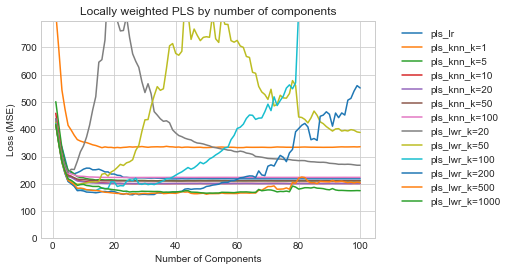

In [13]:
fig, ax = plt.subplots()
ax.set_xlabel("Number of Components")
ax.set_ylabel("Loss (MSE)")
ax.set_title("Locally weighted PLS by number of components")
#ax.plot(x_ls,y_ls,label="lr")

series_labels = scores_df_pls['model'].unique()
for name in series_labels:
    subset = scores_df_pls[scores_df_pls["model"]==name]
    ax.plot(subset["n_comp"],subset["MSE"],label = f"{name}")
ax.set_ylim(0,max_value)
ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
plt.savefig(log_dir / f"summary_pls.png",bbox_inches='tight')

ax.set_ylim(0,5*min_value)
plt.savefig(log_dir / f"summary_pls_compressed.png",bbox_inches='tight')


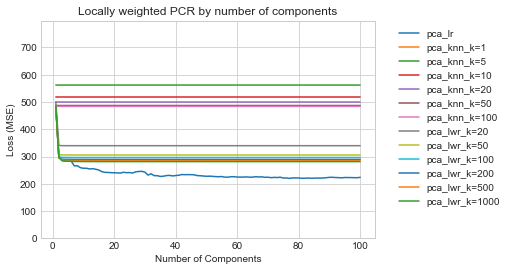

In [14]:
fig, ax = plt.subplots()
ax.set_xlabel("Number of Components")
ax.set_ylabel("Loss (MSE)")
ax.set_title("Locally weighted PCR by number of components")
#ax.plot(x_ls,y_ls,label="lr")

series_labels = scores_df_pcr['model'].unique()
for name in series_labels:
    subset = scores_df_pcr[scores_df_pcr["model"]==name]
    ax.plot(subset["n_comp"],subset["MSE"],label = f"{name}")
ax.set_ylim(0,max_value)
ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
plt.savefig(log_dir / f"summary_pca.png",bbox_inches='tight')

ax.set_ylim(0,5*min_value)
plt.savefig(log_dir / f"summary_pca_compressed.png",bbox_inches='tight')


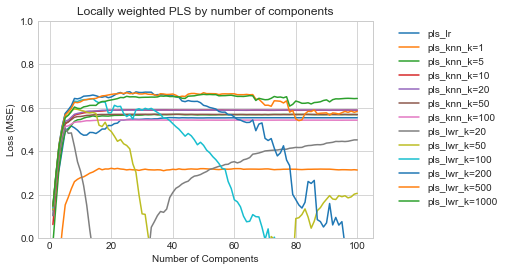

In [15]:
fig, ax = plt.subplots()
ax.set_xlabel("Number of Components")
ax.set_ylabel("R^2 Score")
ax.set_title("Locally weighted PLS by number of components")

series_labels = scores_df_pls['model'].unique()
for name in series_labels:
    subset = scores_df_pls[scores_df_pls["model"]==name]
    ax.plot(subset["n_comp"],subset["R2"],label = f"{name}")


ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
plt.savefig(log_dir / f"r2_plot_pls.png",bbox_inches='tight')
ax.set_ylim(0,1)
plt.savefig(log_dir / f"r2_plot_pls_v2.png",bbox_inches='tight')

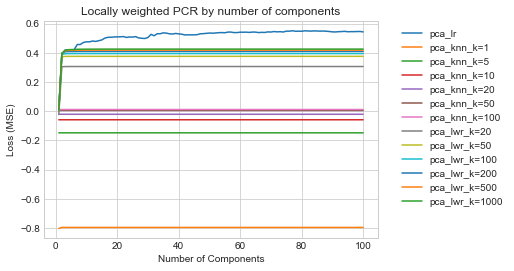

In [16]:
fig, ax = plt.subplots()
ax.set_xlabel("Number of Components")
ax.set_ylabel("R^2 Score")
ax.set_title("Locally weighted PCR by number of components")

series_labels = scores_df_pcr['model'].unique()
for name in series_labels:
    subset = scores_df_pcr[scores_df_pcr["model"]==name]
    ax.plot(subset["n_comp"],subset["R2"],label = f"{name}")


ax.legend(loc='upper right',bbox_to_anchor=(1.4, 1))
plt.savefig(log_dir / f"r2_plot_pcr.png",bbox_inches='tight')
ax.set_ylim(0,1)
plt.savefig(log_dir / f"r2_plot_pcr_v2.png",bbox_inches='tight')
